<h1 style="text-align: center;">California Housing Price</h1>
<h3 style="text-align: center;">Bonifasius Sinurat</h3>

---

## **Libraries Used**

In [1]:
%pip install numpy==2.2.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import shap
import pickle
import scipy.stats as stats
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import Pool, CatBoostRegressor

from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

## **Chapter 1. Business Understanding**

##### **1.1 Context**

Harga rumah merupakan salah satu indikator utama kondisi ekonomi dan kesejahteraan sosial di suatu wilayah. California, sebagai negara bagian terpadat di Amerika Serikat, memiliki variasi harga rumah yang sangat tinggi karena pengaruh faktor geografis, sosial ekonomi, serta jarak terhadap pusat ekonomi utama seperti Los Angeles dan San Francisco. Data yang digunakan dalam project ini bersumber dari sensus California tahun 1990, yang mencakup berbagai fitur demografis dan karakteristik hunian per distrik.

Meskipun data ini bersifat historis dan tidak mencerminkan kondisi harga rumah saat ini, dataset ini tetap relevan sebagai sarana eksplorasi dan pembelajaran dalam memahami hubungan antara fitur-fitur lingkungan dan nilai rumah melalui pendekatan machine learning. [(Pace & Barry, 1997)](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

##### **1.2 Problem Statements**

Berdasarkan kondisi di atas, berikut rumusan masalah bisnis yang ingin dijawab melalui project ini:

* Bagaimana karakteristik demografi dan lingkungan suatu wilayah di California berhubungan dengan harga rumah di wilayah tersebut?

* Faktor apa saja yang memiliki dampak paling signifikan terhadap variasi harga rumah?

* Bagaimana data historis ini dapat membantu pengambil keputusan di sektor properti, pemerintah daerah, dan investor dalam memahami pola harga rumah?

##### **1.3 Goals**

Tujuan spesifik dari project ini adalah:

* Mengidentifikasi dan memahami hubungan antara berbagai fitur demografis dan geografis dengan harga rumah di distrik California.

* Melakukan eksplorasi data secara mendalam untuk menemukan pola yang relevan dalam data historis ini.

* Menyiapkan data melalui tahapan *preprocessing* dan *feature engineering* sehingga siap digunakan untuk membuat model prediktif.

* Menghasilkan insight yang jelas bagi *stakeholder* internal maupun eksternal untuk pengambilan keputusan strategis.

##### **1.4 Analytical Approach**

Pendekatan analitik dalam project ini mencakup beberapa tahapan sistematis berikut:

|    Section    |    Implementation    |
|---------------|-------------------|
| `Data Understanding` | Memahami struktur dan karakteristik data, serta mendeteksi potensi permasalahan awal seperti missing values atau data yang tidak konsisten. |
| `Exploratory Data Analysis (EDA)` | Melakukan analisis deskriptif dan visualisasi data untuk mengidentifikasi hubungan antar variabel serta pola yang mungkin muncul. |
| `Data Preprocessing` | Membersihkan data dengan teknik imputation (KNN atau Iterative), menangani outlier, serta melakukan encoding dan scaling variabel. |
| `Feature Engineering` | Melakukan binning, membuat fitur baru yang relevan, serta memilih fitur yang memiliki dampak signifikan terhadap target prediksi. |
| `Modeling` | Menggunakan algoritma machine learning yang sesuai (seperti regresi linier atau tree-based models) untuk prediksi nilai rumah (dilakukan pada tahap berikutnya). |

##### **1.5 Metric Evaluation (Business Metric, Machine Learning Evaluation Metric)**

Evaluasi project ini menggunakan dua jenis metrik yang telah dipilih secara strategis untuk menyelaraskan dengan pendekatan preprocessing yang telah diterapkan:

* Business Metrics:

    * Menyampaikan *insight* yang dihasilkan untuk **membantu proses pengambil keputusan** (*clarity* and *actionability*).
    
    * **Identifikasi minimal 3 variabel utama** yang terbukti berpengaruh signifikan terhadap harga rumah, baik dari *feature importance* model maupun analisis eksploratif.
    
    * Tingkat akurasi prediksi yang dapat diterima secara bisnis dengan **toleransi kesalahan maksimal 15% dari harga aktual**.

* Machine Learning Evaluation Metrics:

    * **Mean Absolute Error (MAE)** - Metrik utama untuk mengukur rata-rata kesalahan absolut prediksi harga rumah dalam satuan dollar. MAE dipilih karena sifatnya yang *robust* terhadap outlier dan memberikan interpretasi langsung terhadap biaya kesalahan prediksi.
    
    * **Mean Absolute Percentage Error (MAPE)** - Mengukur rata-rata persentase kesalahan prediksi, memberikan perspektif *scale-independent* yang mudah dikomunikasikan kepada stakeholder non-teknis.
    
    * **Mean Squared Log Error (MSLE)** - Metrik tambahan yang selaras dengan transformasi logaritmik pada target variable dan secara natural *robust* terhadap *outlier*, serta lebih menghukum *under-prediction* dibandingkan *over-prediction*.

##### **1.6 Success Criteria**

Project ini dianggap berhasil jika memenuhi kriteria berikut:

* Dataset telah dibersihkan dan diproses hingga siap digunakan untuk modeling.

* Ditemukan minimal 3 variabel yang signifikan secara statistik yang memengaruhi harga rumah, dengan interpretasi yang jelas dan *actionable*.

* Stakeholder internal mampu memahami insight dari hasil analisis dan dapat menggunakannya sebagai referensi untuk pengambilan keputusan strategis lebih lanjut.

* Konsistensi metodologis terjaga mulai dari *preprocessing* hingga evaluasi, dengan justifikasi yang jelas untuk setiap pilihan teknis yang dibuat.

## **Chapter 2. Data Understanding**

##### **2.1 Load Dataset**

In [3]:
df = pd.read_csv(r'D:\Bonifasius\Capstone Project (Machine Learning)\California House\data_california_house.csv')
df.sample(5, random_state=31)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8467     -118.17     33.94                17.0       1145.0           209.0   
1812     -122.07     37.58                16.0       1644.0           251.0   
8472     -118.36     33.89                37.0       1719.0           426.0   
11085    -121.86     37.35                46.0       1448.0           330.0   
13102    -118.37     34.04                42.0       1809.0           424.0   

       population  households  median_income ocean_proximity  \
8467        499.0       202.0         4.6389       <1H OCEAN   
1812       1033.0       267.0         6.5116        NEAR BAY   
8472       1266.0       424.0         3.3750       <1H OCEAN   
11085      1094.0       331.0         2.4968       <1H OCEAN   
13102      1094.0       382.0         2.7670       <1H OCEAN   

       median_house_value  
8467             165500.0  
1812             244300.0  
8472             228000.0  
11085            174100.0  
13102            143000.0

Modifikasi nama kolom agar lebih tampilan dataframe lebih compact

In [4]:
df.rename(columns={
    'housing_median_age':'houseMedAge',
    'total_rooms':'totalRooms',
    'total_bedrooms':'totalBedrooms',
    'median_income':'medIncome',
    'ocean_proximity':'oceanProx',
    'median_house_value':'medHouseVal'
    }, inplace=True)

df.sample(3, random_state=31)

longitude  latitude  houseMedAge  totalRooms  totalBedrooms  population  \
8467    -118.17     33.94         17.0      1145.0          209.0       499.0   
1812    -122.07     37.58         16.0      1644.0          251.0      1033.0   
8472    -118.36     33.89         37.0      1719.0          426.0      1266.0   

      households  medIncome  oceanProx  medHouseVal  
8467       202.0     4.6389  <1H OCEAN     165500.0  
1812       267.0     6.5116   NEAR BAY     244300.0  
8472       424.0     3.3750  <1H OCEAN     228000.0

##### **2.2 Feature Information**

In [5]:
listItem = []

for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), 
                     round((df[col].isna().sum()/len(df[col]))*100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

df_desc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
df_desc

dataFeatures dataType  null  nullPct  unique          uniqueSample
0      longitude  float64     0     0.00     806    [-121.51, -120.16]
1       latitude  float64     0     0.00     836        [33.03, 36.59]
2    houseMedAge  float64     0     0.00      52           [8.0, 14.0]
3     totalRooms  float64     0     0.00    5227      [1955.0, 1323.0]
4  totalBedrooms  float64   137     0.95    1748       [220.0, 1533.0]
5     population  float64     0     0.00    3498      [4917.0, 3543.0]
6     households  float64     0     0.00    1649        [868.0, 678.0]
7      medIncome  float64     0     0.00    9797      [4.6211, 6.1985]
8      oceanProx   object     0     0.00       5    [NEAR BAY, ISLAND]
9    medHouseVal  float64     0     0.00    3548  [376700.0, 202300.0]

| Feature | Description | Impact to Business |
|---------| ----------- | ------------------ |
| `longitude` | Garis bujur lokasi distrik (blok) rumah. | Lokasi geografis dekat pantai atau pusat kota besar umumnya bisa menaikkan harga rumah. |
| `latitude`| Garis lintang lokasi distrik rumah. | Semakin dekat ke area ekonomi seperti San Francisco, biasanya harga semakin tinggi. |
| `houseMedAge` | Usia median rumah dalam distrik tersebut. | Rumah yang lebih baru biasanya dihargai lebih tinggi dibanding yang tua. |
| `totalRooms` | Total jumlah kamar dalam distrik tersebut. | Lebih banyak kamar biasanya terkait dengan harga rumah yang lebih tinggi. |
| `totalBedrooms` | Total jumlah kamar tidur dalam distrik tersebut. | Ukuran rumah secara umum bisa berpengaruh terhadap harga rumah. |
| `population` | Jumlah populasi total dalam distrik tersebut. | Populasi tinggi bisa menandakan permintaan properti tinggi, menaikkan harga properti. |
| `households` | Jumlah total rumah tangga yang tinggal di suatu distrik. | Jumlah rumah tangga yang besar dapat meningkatkan kebutuhan hunian dan memengaruhi nilai properti di distrik tersebut. |
| `medIncome` | Pendapatan median untuk rumah tangga dalam satu distrik. (diukur dalam puluhan ribu USD) | Pendapatan yang tinggi dalam suatu distrik biasanya mendorong peningkatan harga rumah dan ketertarikan investor. |
| `oceanProx` | Kategori kedekatan lokasi distrik dengan laut. | Rumah yang dekat laut atau memiliki pemandangan laut biasanya bernilai tinggi. |
| `medHouseVal` | Nilai median harga rumah dalam distrik tersebut (USD). | Target utama dalam analisis bisnis ini untuk estimasi harga dan investasi properti. |

##### **2.3 Statistics Summary**

In [6]:
display(df.shape, df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   longitude      14448 non-null  float64
 1   latitude       14448 non-null  float64
 2   houseMedAge    14448 non-null  float64
 3   totalRooms     14448 non-null  float64
 4   totalBedrooms  14311 non-null  float64
 5   population     14448 non-null  float64
 6   households     14448 non-null  float64
 7   medIncome      14448 non-null  float64
 8   oceanProx      14448 non-null  object 
 9   medHouseVal    14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


(14448, 10)

None

In [7]:
display(df.describe(), df.describe(include='O'))

longitude      latitude   houseMedAge    totalRooms  totalBedrooms  \
count  14448.000000  14448.000000  14448.000000  14448.000000   14311.000000   
mean    -119.566647     35.630093     28.618702   2640.132683     538.260709   
std        2.006587      2.140121     12.596694   2191.612441     423.577544   
min     -124.350000     32.540000      1.000000      2.000000       1.000000   
25%     -121.800000     33.930000     18.000000   1451.000000     295.000000   
50%     -118.490000     34.260000     29.000000   2125.000000     435.000000   
75%     -118.000000     37.710000     37.000000   3148.000000     647.000000   
max     -114.310000     41.950000     52.000000  32627.000000    6445.000000   

         population    households     medIncome    medHouseVal  
count  14448.000000  14448.000000  14448.000000   14448.000000  
mean    1425.157323    499.508929      3.866667  206824.624516  
std     1149.580157    383.098390      1.891158  115365.476182  
min        3.000000      1.000000      0.499900   14999.000000  
25%      784.000000    279.000000      2.570600  119600.000000  
50%     1165.000000    410.000000      3.539100  180000.000000  
75%     1724.000000    604.000000      4.736100  263900.000000  
max    35682.000000   6082.000000     15.000100  500001.000000

oceanProx
count       14448
unique          5
top     <1H OCEAN
freq         6369

Hasil ringkasan statistik untuk dataset California Housing:

- Dataset terdiri dari 10 fitur utama (numerikal & kategorikal) dengan total 14.448 baris data.

Tipe data:

- 9 fitur numerik (float) seperti longitude, houseMedAge, totalRooms, dst.

- 1 fitur kategorikal (oceanProx) yang menggambarkan kedekatan distrik dengan laut.

- Tidak terdapat nilai negatif pada fitur numerik, kecuali pada longitude (karena memang merepresentasikan posisi geografis di belahan barat).

- *Missing value* hanya ditemukan pada fitur `totalBedrooms` (jumlah kamar tidur).

- Distribusi beberapa fitur tampak skewed (tidak simetris), terlihat dari selisih antara nilai mean dan median yang cukup jauh, misal pada `totalRooms`, `totalBedrooms`, dan `medHouseVal`.

- Fitur `oceanProx` memiliki 5 kategori unik, dengan kategori <1H OCEAN menjadi yang paling sering muncul (freq = 6.369).

##### **2.4 Identify Missing Values**

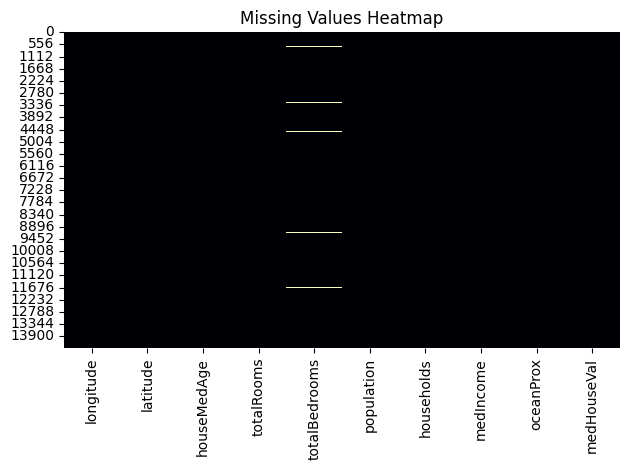

In [8]:
# Visualize missing values
sns.heatmap(df.isnull(), cbar=False, cmap='magma')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

In [9]:
print(f'Jumlah NaN pada Dataset: {df.isna().sum().sum()}')

Jumlah NaN pada Dataset: 137


##### **2.6 Identify Anomaly Values**

**Duplicate Values**

In [10]:
display(df.duplicated().sum())

np.int64(0)

**Outlier**

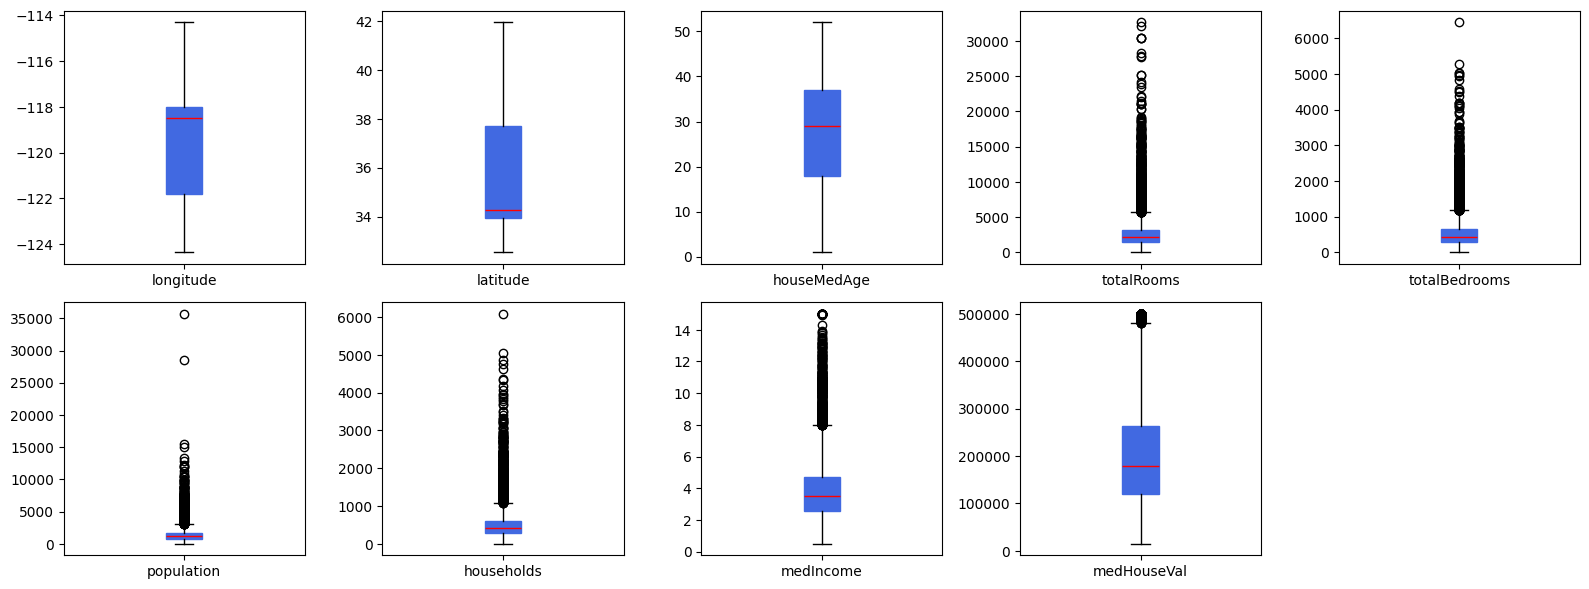

In [11]:
num_cols = df.drop('oceanProx', axis=1).columns

df[num_cols].plot(kind='box', subplots=True, layout=(2, 5),
                  figsize=(16, 6),
                  patch_artist=True,
                  color=dict(boxes='royalblue', whiskers='black', medians='red', caps='black'))

plt.tight_layout()
plt.show()

Berdasarkan boxplot di atas, menunjukkan bahwa mayoritas fitur seperti `totalRooms`, `totalBedrooms`, `population`, `households`, dan `medIncome` memiliki sebaran yang banyak mengandung nilai ekstrem di sisi atas.

## **Chapter 3. Exploratory Data Analysis**

##### **3.1 Univariate Analysis**

In [12]:
def inspect_outlier_iqr(df, num_cols, fold=1.5, tail='both'):
    ''' -> [0] DataFrame of all outliers (union across columns)
        -> [1] Summary DataFrame of outlier stats per column
        Uses IQR * fold, and optionally tail='both' | 'right' | 'left'
    '''
    outlier_summary = []
    outlier_indices = set()
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - fold * IQR if tail in ['both', 'left'] else -np.inf
        upper = Q3 + fold * IQR if tail in ['both', 'right'] else np.inf

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_indices.update(outliers.index)

        outlier_summary.append({
            'Kolom': col,
            'Jumlah Outlier': outliers.shape[0],
            'Lower Bound': lower,
            'Upper Bound': upper,
            'Persentase Outlier': round(100 * outliers.shape[0] / len(df), 2)
        })
    
    outlier_df = pd.DataFrame(outlier_summary).sort_values(by='Jumlah Outlier', ascending=False)
    all_outliers = df.loc[list(outlier_indices)]

    return all_outliers, outlier_df

**Analisis Outlier secara Kuantitatif (IQR)**

Untuk analisis lebih lanjut, dilakukan identifikasi *outlier* menggunakan metode IQR dengan `fold=1.5` dan `tail='both'` pada fitur numerik non-geografis.

In [13]:
num_cols = df.select_dtypes(include='number').drop(['latitude','longitude'], axis=1).columns.tolist()

outlier_rows, outlier_stats = inspect_outlier_iqr(df, num_cols)

display(outlier_stats)
print(f'Jumlah baris outlier: {len(outlier_rows)} ({100 * len(outlier_rows) / len(df):.2f}%)')

Kolom  Jumlah Outlier  Lower Bound   Upper Bound  \
1     totalRooms             900  -1094.50000    5693.50000   
2  totalBedrooms             879   -233.00000    1175.00000   
4     households             842   -208.50000    1091.50000   
3     population             827   -626.00000    3134.00000   
6    medHouseVal             757 -96850.00000  480350.00000   
5      medIncome             482     -0.67765       7.98435   
0    houseMedAge               0    -10.50000      65.50000   

   Persentase Outlier  
1                6.23  
2                6.08  
4                5.83  
3                5.72  
6                5.24  
5                3.34  
0                0.00

Jumlah baris outlier: 2092 (14.48%)


Hasilnya menunjukkan bahwa fitur dengan jumlah *outlier* terbanyak adalah `totalRooms` dan `totalBedrooms`, disusul oleh `households` dan `population`. Sebagian besar *outlier* berada di sisi atas, mencerminkan area dengan densitas tinggi atau rumah dengan kapasitas besar.

Proporsi *outlier* berada di kisaran **3–6%** per fitur, cukup signifikan dan butuh investigasi lebih lanjut agar dalam tahapan *preprocessing* tidak mendistorsi model.

In [14]:
outlier_rows[df['medHouseVal'] > 480350].sample(10, random_state=31)

longitude  latitude  houseMedAge  totalRooms  totalBedrooms  \
3061     -118.34     34.08         52.0      2756.0          542.0   
7715     -122.08     37.24         21.0       427.0           63.0   
14048    -122.16     37.42         34.0      4448.0          610.0   
5583     -118.36     34.10         36.0      2963.0          838.0   
11549    -118.29     34.11         49.0      2850.0          379.0   
6533     -118.57     34.09         14.0      7970.0         1142.0   
6107     -118.15     33.76         36.0      2916.0          785.0   
8771     -117.81     33.68          4.0      1545.0          304.0   
10154    -122.15     37.46         39.0       906.0          109.0   
13602    -118.48     34.16         32.0      2108.0          309.0   

       population  households  medIncome   oceanProx  medHouseVal  
3061        971.0       510.0     5.5871   <1H OCEAN     500001.0  
7715        182.0        70.0    11.3283   <1H OCEAN     500001.0  
14048      2571.0       581.0    11.0492  NEAR OCEAN     500001.0  
5583       1129.0       745.0     2.5588   <1H OCEAN     500001.0  
11549      1113.0       380.0    12.9591   <1H OCEAN     500001.0  
6533       2926.0      1096.0    11.2866   <1H OCEAN     500001.0  
6107       1183.0       749.0     3.5985  NEAR OCEAN     500001.0  
8771        788.0       296.0     4.5469   <1H OCEAN     500001.0  
10154       353.0       112.0    10.3942    NEAR BAY     500001.0  
13602       769.0       274.0     8.7172   <1H OCEAN     500001.0

In [15]:
len(outlier_rows[df['medHouseVal'] > 480350]['medHouseVal'])

757

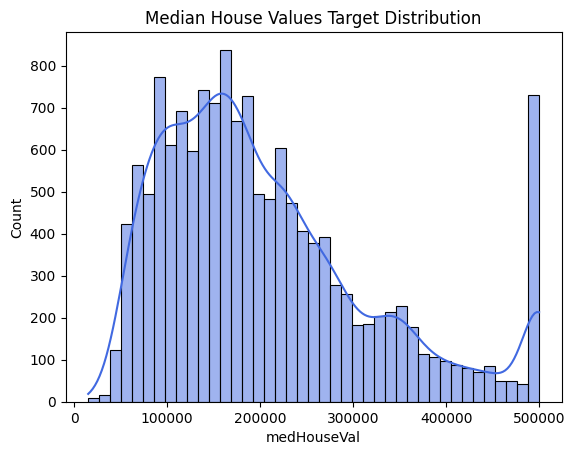

In [16]:
sns.histplot(x='medHouseVal', kde=True, data=df, color='royalblue')
plt.title('Median House Values Target Distribution')
plt.show()

In [17]:
outlier_rows[outlier_rows['medHouseVal'] > 480350]['medHouseVal'].value_counts().head()

medHouseVal
500001.0    678
500000.0     18
483300.0      6
495500.0      2
490800.0      2
Name: count, dtype: int64

Untuk memastikan pendekatan deteksi *outlier* tidak mengeliminasi rumah-rumah bernilai tinggi, dilakukan pengecekan terhadap baris yang terdeteksi sebagai *outlier* dan memiliki harga rumah (`medHouseVal`) di atas 480.350.

Hasilnya menunjukkan bahwa terdapat 757 rumah mahal yang terklasifikasi sebagai *outlier*, dengan mayoritas memiliki nilai maksimum (500001.0) yang merepresentasikan adanya indikasi pembatasan data saat proses sensus dilakukan. Dengan kata lain, rumah-rumah mewah yang harganya lebih dari 500.000, direpresentasikan dengan nilai tersebut yang membuat hal ini menjadi masalah untuk divalidasi. Karena berbagai rumah mewah ini juga ada yang `totalRooms` dan `medIncome` sedikit, ada juga yang banyak.

Temuan ini mengindikasikan bahwa tidak semua *outlier* adalah data error, namun sebagian besar *outlier* yang ada, mengandung `medHouseVal` yang tidak bisa divalidasi nilainya, dan dapat mendistorsi model. Oleh karena itu, beberapa strategi *outlier* seperti `capping` akan dipertimbangkan **serta menindaklanjuti rumah dengan harga pada batas atas di angka 500.000**.

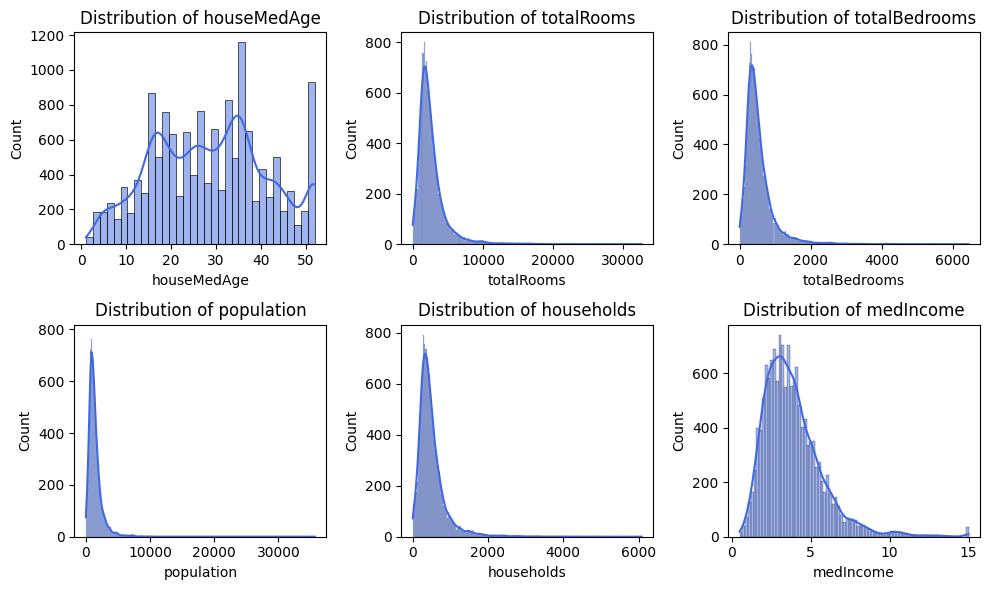

In [18]:
plt.figure(figsize=(10,6))

for idx, col in enumerate(df[num_cols[:-1]]):
    sns.histplot(df[col], kde=True, ax=plt.subplot(2,3,idx+1), color='royalblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [19]:
display(df['houseMedAge'].value_counts().head(),
        df['houseMedAge'].nunique())

houseMedAge
52.0    896
36.0    585
35.0    573
16.0    523
17.0    502
Name: count, dtype: int64

52

Sebaran distribusi untuk `Numerical Features` menunjukkan karakteristik yang cukup bervariasi:

* `houseMedAge` memiliki distribusi yang relatif mendekati uniform, dengan puncak pada usia 20–35 tahun. Ini mencerminkan sebaran rumah yang cukup merata dari segi umur bangunan. Namun, juga terdapat *censoring* pada rumah dengan usia 52 tahun.

* Fitur seperti `totalRooms`, `totalBedrooms`, `population`, dan `households` menunjukkan distribusi *right-skewed* cukup ekstrem. Mayoritas nilai berada di rentang rendah, tetapi terdapat sejumlah kecil observasi dengan nilai sangat tinggi, yang merepresentasikan blok besar atau area padat.

* `medIncome` juga memiliki distribusi *right-skewed*, dengan mayoritas penduduk memiliki pendapatan menengah ke bawah, dan hanya sebagian kecil yang memiliki pendapatan sangat tinggi (di atas 10).

Pola distribusi ini mengonfirmasi temuan sebelumnya dari boxplot dan analisis IQR, bahwa *outlier* pada fitur-fitur ini terutama berada di sisi kanan distribusi. Oleh karena itu, dibutuhkan strategi *preprocessing* yang mampu menangani *skewness* dan *outlier*, terutama untuk fitur yang menjadi indikator rumah mewah dan area elite.

##### **3.2 Bivariate Analysis**

In [20]:
# Cek jumlah properti berdasarkan Ocean Proximity group
print(f"Jumlah properti di tiap Ocean Proximity group: {df['oceanProx'].value_counts()}")

Jumlah properti di tiap Ocean Proximity group: oceanProx
<1H OCEAN     6369
INLAND        4576
NEAR OCEAN    1879
NEAR BAY      1622
ISLAND           2
Name: count, dtype: int64


In [21]:
# Cek median price untuk tiap Ocean Proximity group
df_median_price = df.groupby(by=['oceanProx']).agg({'medHouseVal':'median'}).reset_index()
df_median_price = df_median_price.set_index('oceanProx')
df_median_price = df_median_price.sort_values('medHouseVal', ascending=False)
df_median_price.reset_index()

oceanProx  medHouseVal
0      ISLAND     351100.0
1    NEAR BAY     230800.0
2  NEAR OCEAN     228600.0
3   <1H OCEAN     214800.0
4      INLAND     108800.0

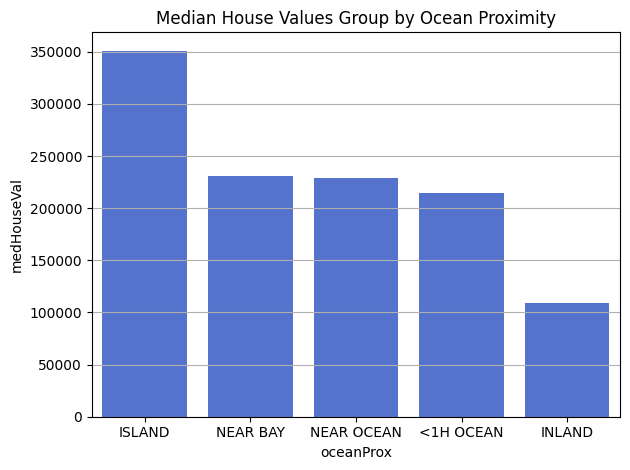

In [22]:
sns.barplot(df_median_price.reset_index(), x='oceanProx', y='medHouseVal',
            color='royalblue', estimator='median').set_title('Median House Values Group by Ocean Proximity')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

`Ocean Proximity`:

Terdapat pola yang jelas antara kedekatan distrik dengan laut dan harga median rumah: 

> Semakin dekat ke laut, harga rumah cenderung lebih tinggi (ISLAND, NEAR OCEAN, NEAR BAY)

Sementara area yang jauh dari laut (<1H OCEAN & INLAND) memiliki harga lebih rendah.

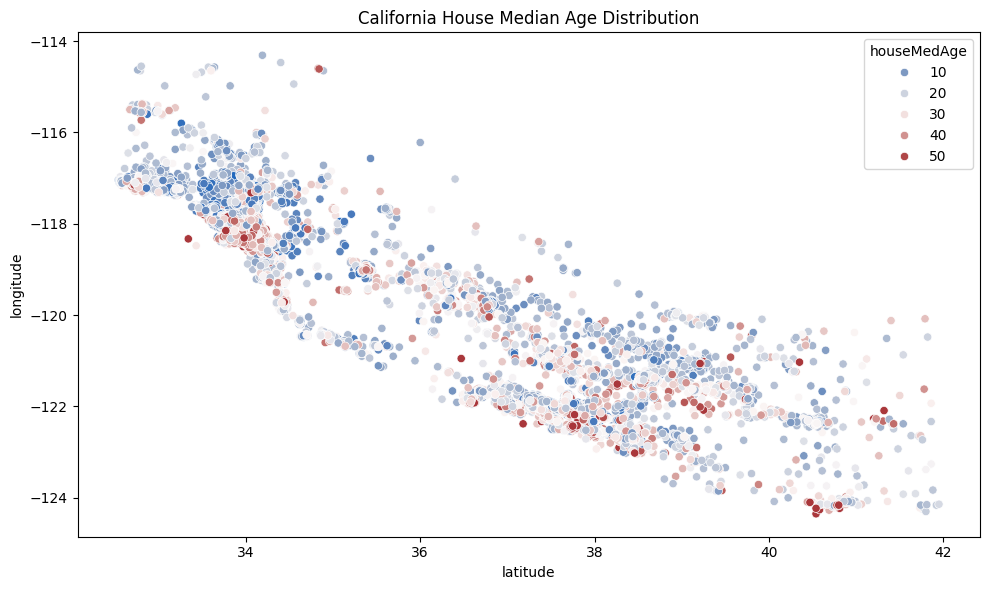

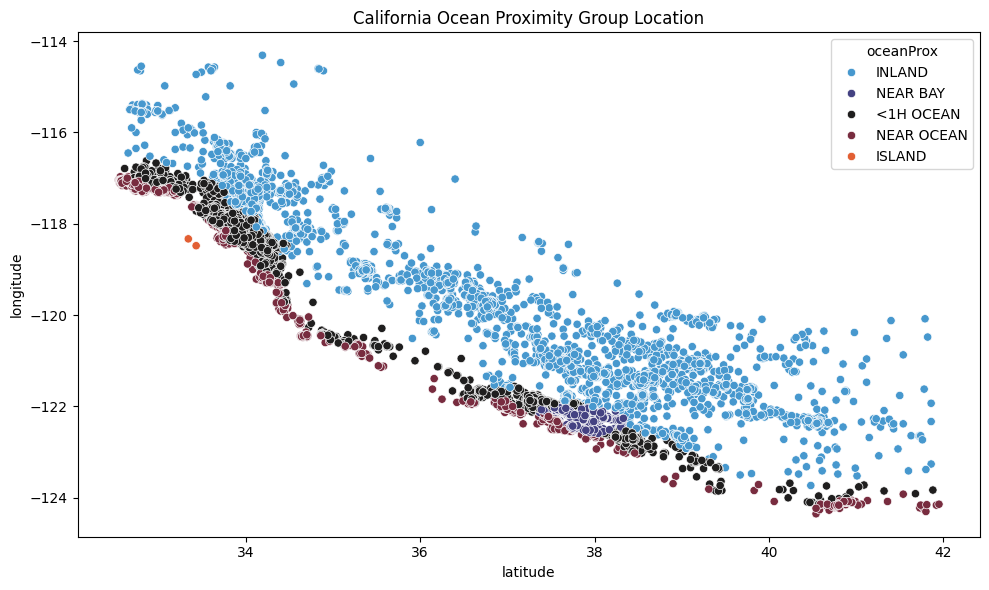

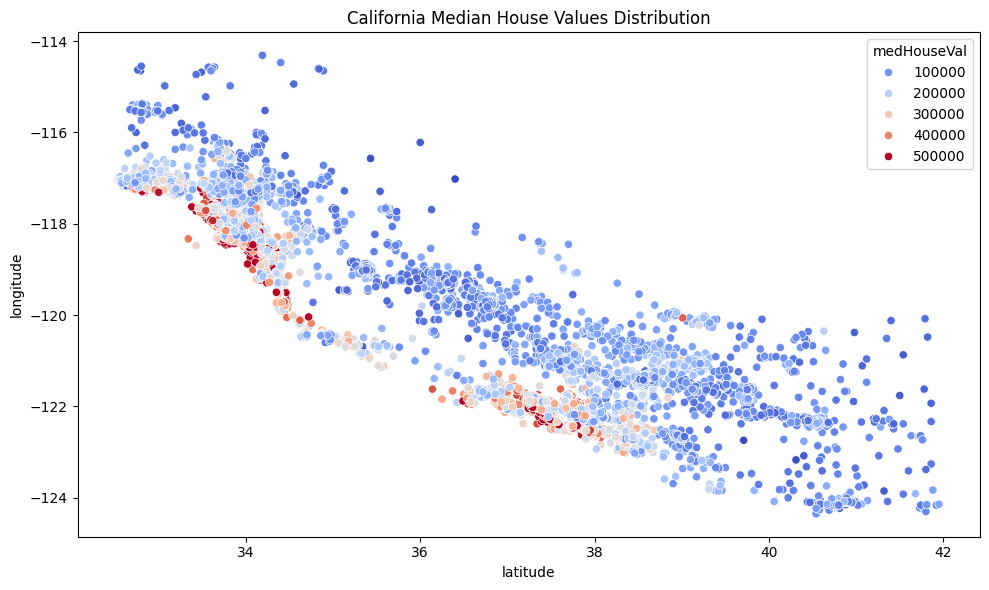

In [23]:
# Plot lokasi 'House Median Age'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='latitude', y='longitude',
                hue='houseMedAge', hue_order='houseMedAge', palette='vlag') \
                .set_title('California House Median Age Distribution')
plt.tight_layout()

# Plot lokasi 'Ocean Proximity'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='latitude', y='longitude',
                hue='oceanProx', palette='icefire') \
                .set_title('California Ocean Proximity Group Location')
plt.tight_layout()

# Plot persebaran 'population'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='latitude', y='longitude',
                hue='medHouseVal', hue_order='medHouseVal', palette='coolwarm') \
                .set_title('California Median House Values Distribution')
plt.tight_layout()
plt.show()

`House Median Age`:

* Sebaran usia rumah relatif merata di seluruh wilayah California, tetapi terdapat kecenderungan rumah-rumah lebih tua berada di bagian selatan dan pesisir barat, sedangkan rumah yang lebih baru lebih banyak ditemukan di bagian utara atau agak menjauh dari garis pantai.

`Ocean Proximity`:

* Distrik yang berdekatan dengan laut (kategori <1H OCEAN, NEAR OCEAN, ISLAND) secara geografis lebih terkonsentrasi di sepanjang pesisir barat California, sedangkan kategori INLAND mendominasi area tengah dan timur, yang letaknya jauh dari pantai.

`Median House Value`:

* Rumah dengan nilai median harga tertinggi cenderung terkonsentrasi di daerah pesisir, khususnya sekitar area Los Angeles dan San Francisco, serta wilayah yang dekat dengan laut atau teluk (NEAR BAY, <1H OCEAN). Sementara itu, area pedalaman (INLAND) umumnya memiliki harga median rumah yang jauh lebih rendah.

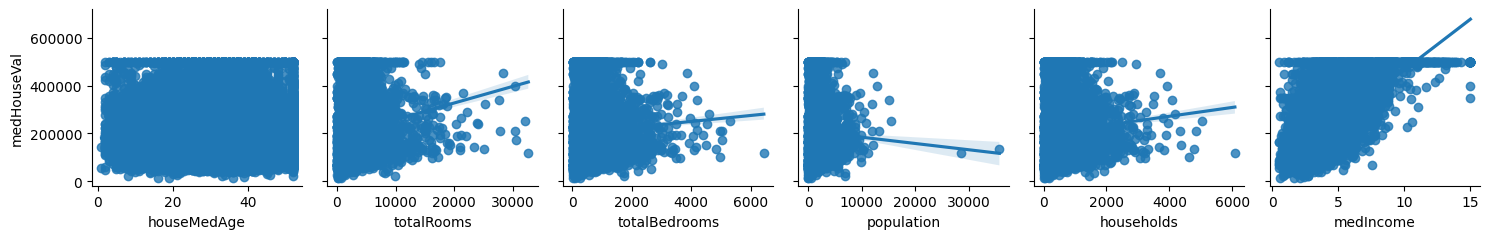

In [24]:
sns.pairplot(data=df,
             x_vars=num_cols[:-1], 
             y_vars='medHouseVal',
             kind='reg')
plt.tight_layout()
plt.show()

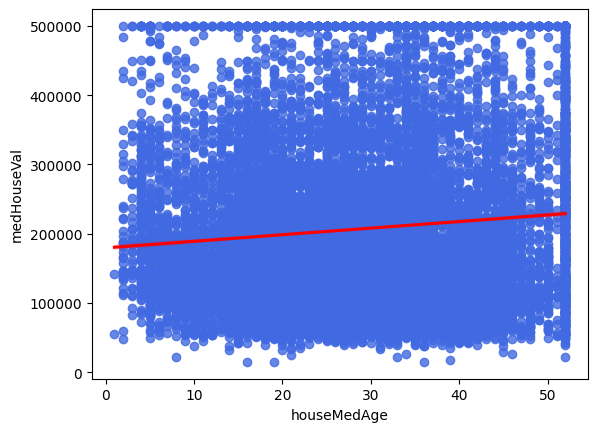

In [25]:
sns.regplot(x=df['houseMedAge'], y=df['medHouseVal'],fit_reg=True, color='royalblue', line_kws={'color':'red'});

In [26]:
df[num_cols].corr()

houseMedAge  totalRooms  totalBedrooms  population  households  \
houseMedAge       1.000000   -0.367868      -0.329448   -0.299736   -0.312394   
totalRooms       -0.367868    1.000000       0.931993    0.853460    0.919292   
totalBedrooms    -0.329448    0.931993       1.000000    0.874618    0.978561   
population       -0.299736    0.853460       0.874618    1.000000    0.905061   
households       -0.312394    0.919292       0.978561    0.905061    1.000000   
medIncome        -0.120396    0.199549      -0.004160    0.006284    0.016365   
medHouseVal       0.103863    0.131972       0.045915   -0.026183    0.061581   

               medIncome  medHouseVal  
houseMedAge    -0.120396     0.103863  
totalRooms      0.199549     0.131972  
totalBedrooms  -0.004160     0.045915  
population      0.006284    -0.026183  
households      0.016365     0.061581  
medIncome       1.000000     0.693273  
medHouseVal     0.693273     1.000000

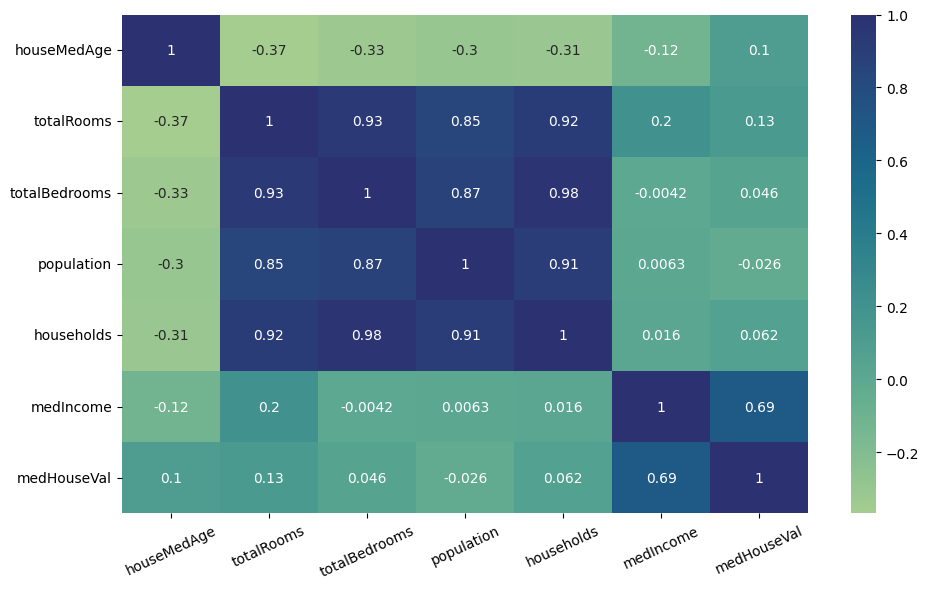

In [27]:
plt.figure(figsize=(10,6))

sns.heatmap(df[num_cols].corr(), annot=True, cmap='crest')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### **3.3 EDA Insights – Key Patterns and Business Relevance**

**1. Distribusi dan Tendensi Sentral**

* Sebagian besar fitur numerik seperti `totalRooms`, `totalBedrooms`, `population`, dan `households` memiliki distribusi *right-skewed* yang ekstrem, menunjukkan bahwa mayoritas distrik memiliki nilai rendah, namun terdapat sejumlah kecil distrik dengan nilai sangat tinggi yang mewakili blok besar atau kawasan padat penduduk.
* Fitur `medIncome` juga cenderung *right-skewed*, namun dengan puncak di kisaran 3–6, mencerminkan distribusi pendapatan masyarakat menengah ke bawah di California.
* Harga rumah (`medHouseVal`) memiliki median sekitar $180,000, **namun dengan distribusi yang tersebar lebar, termasuk batas atas yang terkunci di $500,001**, mengindikasikan keberadaan segmen properti mewah dalam jumlah signifikan.

**2. Korelasi antar Fitur**

* `medIncome` memiliki korelasi tertinggi terhadap harga rumah **(0.69)**. Wilayah dengan pendapatan lebih tinggi secara konsisten menunjukkan harga rumah yang lebih tinggi, menjadikannya indikator utama nilai properti.
* Fitur seperti `totalRooms`, `totalBedrooms`, `population`, dan `households` saling berkorelasi sangat tinggi. Namun, kontribusinya terhadap harga rumah relatif rendah.
* `houseMedAge` memiliki korelasi lemah **(0.10)**, yang menandakan tidak ada tren yang konsisten bahwa rumah yang lebih baru cenderung lebih mahal.

**3. Pengaruh Lokasi (Ocean Proximity)**

* Kedekatan dengan laut terbukti berpengaruh kuat terhadap nilai properti: **kategori ISLAND, NEAR BAY, dan NEAR OCEAN memiliki harga median signifikan lebih tinggi dibandingkan INLAND dan <1H OCEAN.**

* Pola geografis harga rumah sangat terlihat: **properti bernilai tinggi terkonsentrasi di sepanjang garis pantai**, terutama di kawasan metropolitan seperti San Francisco dan Los Angeles.

**4. Karakteristik Demografi dan Rumah Tangga**

* Jumlah populasi dan rumah tangga tidak menunjukkan hubungan kuat dengan harga rumah, namun bisa menjadi indikator kepadatan.

* Fitur turunan seperti `roomsPerHouseholds` dan `bedroomsPerRoom` dapat menawarkan informasi lebih tajam tentang kualitas hunian, efisiensi ruang, dan daya beli menjadikannya kandidat fitur penting untuk pemodelan.

**Key Takeaways untuk Potensi Investasi**

* **Memprioritaskan area dengan pendapatan median tinggi** sebagai sinyal kuat harga rumah premium.
* **Berfokus pada properti pesisir** sebagai lokasi strategis dekat laut memiliki nilai jual yang tinggi dan stabil.
* **Mempertimbangkan usia rumah sebagai pelengkap prediksi nilai**, meski bukan faktor dominan.
* **Peta geografis dan cluster lokasi** memainkan peran penting dalam mendeteksi peluang investasi properti bernilai tinggi.

## **Chapter 4. Data Preprocessing**

##### **4.1 Data Transformation**

In [28]:
outlier_rows[outlier_rows['medHouseVal'] > 480350]['medHouseVal'].value_counts().head()

medHouseVal
500001.0    678
500000.0     18
483300.0      6
495500.0      2
490800.0      2
Name: count, dtype: int64

Terlihat bahwa mayoritas *outlier* pada `medHouseValue` merupakan *censoring* pada data sensus pada saat pengumpulan data dilakukan. **Dengan ketiadaan sarana untuk memvalidasi harga rumah mewah yang memiliki harga diatas 500.000, maka diputuskan untuk menghapus 678 baris data tersebut agar meminimalisir error yang dihasilkan oleh model dan tidak bisa divalidasi**. Rumah dengan harga 500.000 sendiri tidak di-*drop* karena masih bisa dijadikan data validasi. 

In [29]:
df.drop(index=outlier_rows[outlier_rows['medHouseVal'] > 500000].index, inplace=True)

In [30]:
display(
    df['medHouseVal'].describe(),
    df.shape
)

count     13770.000000
mean     192389.360712
std       97589.825606
min       14999.000000
25%      116700.000000
50%      174000.000000
75%      248000.000000
max      500000.000000
Name: medHouseVal, dtype: float64

(13770, 10)

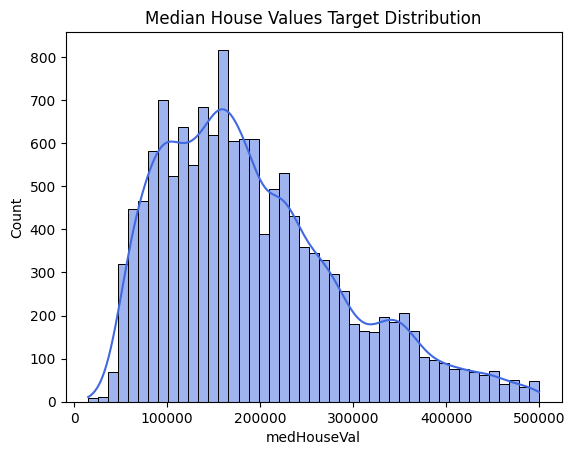

In [31]:
sns.histplot(x='medHouseVal', kde=True, data=df, color='royalblue')
plt.title('Median House Values Target Distribution')
plt.show()

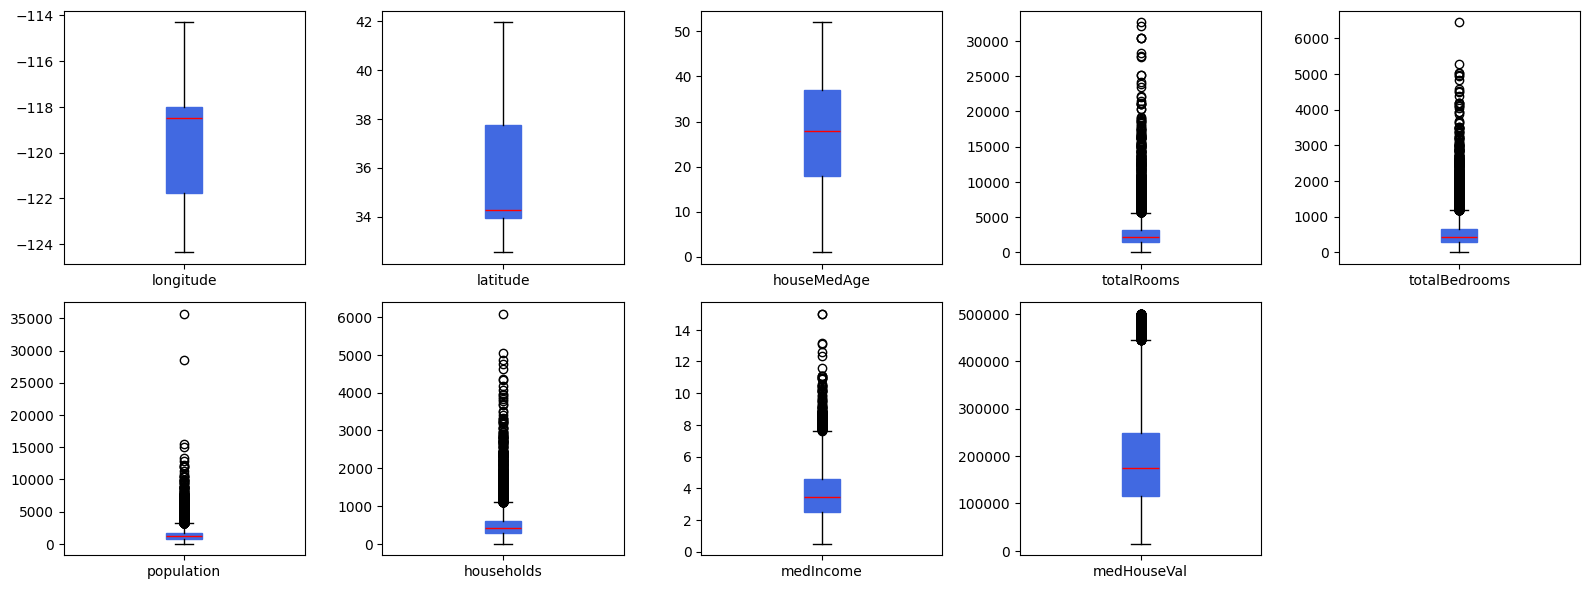

In [32]:
num_cols = df.drop('oceanProx', axis=1).columns

df[num_cols].plot(kind='box', subplots=True, layout=(2, 5),
                  figsize=(16, 6),
                  patch_artist=True,
                  color=dict(boxes='royalblue', whiskers='black', medians='red', caps='black'))

plt.tight_layout()
plt.show()

Setelah dilakukan penanganan rumah dengan harga diatas 500.000, variasi distribusi data dan juga eksistensi *outlier* dari berbagai fitur yang ada tetap terjaga.

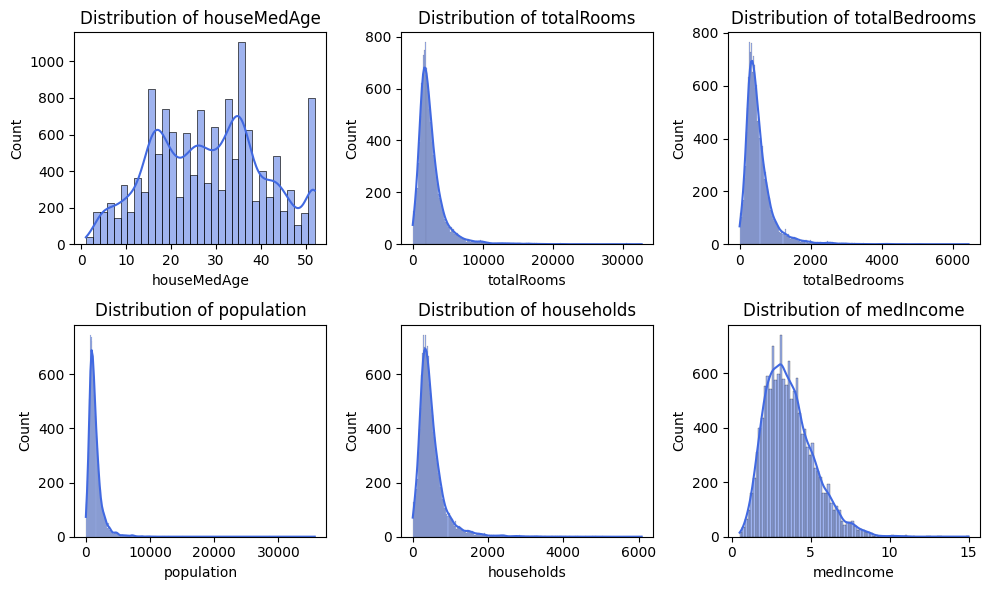

In [33]:
plt.figure(figsize=(10,6))

for idx, col in enumerate(df[num_cols[2:-1]]):
    sns.histplot(df[col], kde=True, ax=plt.subplot(2,3,idx+1), color='royalblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [34]:
df['houseMedAge'].value_counts().head()

houseMedAge
52.0    770
36.0    554
35.0    550
16.0    514
17.0    493
Name: count, dtype: int64

Terlihat pada `houseMedAge` juga terdapat *censoring* dimana rumah dengan usia "tua", di-identifikasi dengan usia 52 tahun. Namun, **tidak dilakukan *drop* pada `houseMedAge` karena validasi dan evaluasi tetap bisa dilakukan nantinya melalui target yang ada**. Tidak seperti kasus sebelumnya dengan `medHouseVal`.

In [35]:
display(
    df['oceanProx'].value_counts(),
    df_median_price
)

oceanProx
<1H OCEAN     5998
INLAND        4561
NEAR OCEAN    1732
NEAR BAY      1477
ISLAND           2
Name: count, dtype: int64

medHouseVal
oceanProx              
ISLAND         351100.0
NEAR BAY       230800.0
NEAR OCEAN     228600.0
<1H OCEAN      214800.0
INLAND         108800.0

`oceanProx` juga menunjukkan pola menarik yang setiap kategorinya memiliki urutan yang logis sesuai tren harga. Oleh karena itu, *encoding* akan diterapkan menggunakan `ordinal encoding`, agar model dapat memahami urutan nilai tersebut dan tidak hanya membedakan kategori seperti pada `one-hot encoding`.

##### **4.2 Train-Test Split**

Untuk memastikan evaluasi model yang objektif dan menghindari data leakage, dataset dibagi menjadi dua bagian: **training set** (80%) untuk proses pelatihan model dan **test set** (20%) untuk evaluasi performa model pada data yang belum pernah dilihat sebelumnya.

In [36]:
# Split dataset
X = df.drop('medHouseVal', axis=1)
y = df['medHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

##### **4.3 Missing Values Imputation**

Sebelum melakukan `modelling`, perlu dipastikan tidak ada *missing values* yang bisa mengganggu performa model. Berdasarkan hasil split data, akan dilakukan cek *missing values* pada masing-masing data set.

In [37]:
display(X_train.isna().sum().sum(),
        X_test.isna().sum().sum(),
        y_train.isna().sum().sum(),
        y_test.isna().sum().sum())

np.int64(106)

np.int64(25)

np.int64(0)

np.int64(0)

In [38]:
display(
    X_train.isna().sum(),
    X_test.isna().sum()
)

longitude          0
latitude           0
houseMedAge        0
totalRooms         0
totalBedrooms    106
population         0
households         0
medIncome          0
oceanProx          0
dtype: int64

longitude         0
latitude          0
houseMedAge       0
totalRooms        0
totalBedrooms    25
population        0
households        0
medIncome         0
oceanProx         0
dtype: int64

Jumlah *missing values* pada **train set** teridentifikasi sebanyak **106** dan pada **test set** sebanyak **25** (seluruhnya berada di fitur `totalBedrooms`).

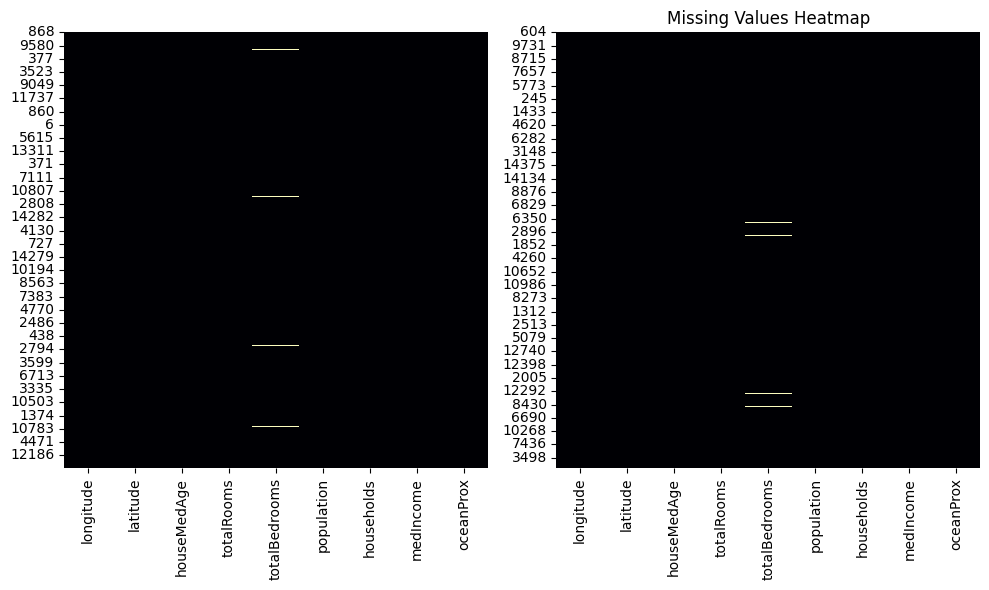

In [39]:
# Visualize missing values
fig, axes = plt.subplots(1,2, figsize=(10,6))

sns.heatmap(X_train.isnull(), cbar=False, cmap='magma', ax=axes[0])
sns.heatmap(X_test.isnull(), cbar=False, cmap='magma', ax=axes[1])
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

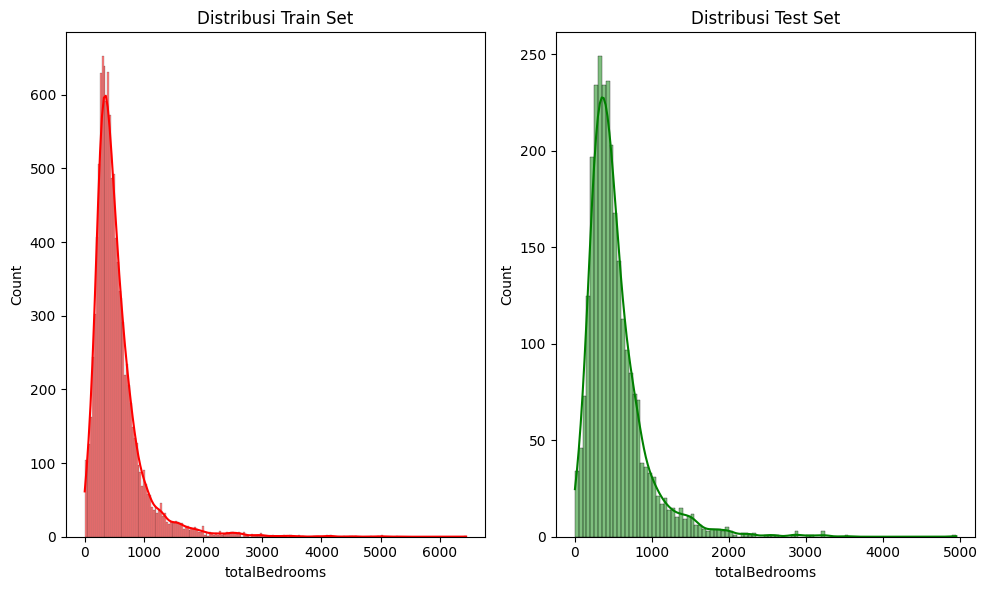

In [40]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

sns.histplot(X_train['totalBedrooms'], ax=axes[0], color='red', kde=True)
axes[0].set_title('Distribusi Train Set')

sns.histplot(X_test['totalBedrooms'], ax=axes[1], color='green', kde=True)
axes[1].set_title('Distribusi Test Set')

plt.tight_layout()
plt.show()

Karena data mengandung *outlier* dan distribusi tidak normal, dua metode imputasi dicoba: 

- `Iterative Imputer` *(initial_strategy = median)*

- `KNN Imputer`

Imputasi dikombinasikan dengan `RobustScaler` untuk fitur numerik dan `OrdinalEncoder` untuk fitur kategorikal, semuanya diatur dalam pipeline. Untuk tujuan perbandingan hasil metode imputasi, metrik dengan *MAE* terendah dipilih sebagai strategi utama agar prediksi harga rumah lebih akurat dan andal. Sedangkan ketiga metrik *(MAE, MAPE, & MSLE)* akan digunakan pada saat `Model Development`.

In [41]:
# Setup Columns
num_cols = X_train.select_dtypes('number').columns.tolist()
cat_cols = X_train.select_dtypes('object').columns.tolist()

# Setup Ordinal Encoding
medPerCat = X_train.copy()
medPerCat['medHouseValue'] = y_train
medPerCat = medPerCat.groupby('oceanProx')['medHouseValue'].median().sort_values(ascending=False)
ordinal_order = list(medPerCat.index)
ordinal_order = ordinal_order[::-1]
ordinal_order

['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND']

In [42]:
# Model candidates
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(random_state=31),
    'Lasso': Lasso(random_state=31),
    'Tree': DecisionTreeRegressor(random_state=31),
    'Forest': RandomForestRegressor(random_state=31),
    'KNN': KNeighborsRegressor(),
    'XGB': XGBRegressor(random_state=31),
    'CTB': CatBoostRegressor(random_state=31)
}

In [43]:
def make_preprocessor(imputer):
    num_pipe = Pipeline([
        ('imputer', imputer),
        ('scaler', RobustScaler())
    ])
    cat_pipe = Pipeline([
        ('ordinal_enc', OrdinalEncoder(categories=[ordinal_order]))
    ])
    return ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

In [44]:
def evaluate_pipeline(preprocessor, models, primary_metric='MAE'):
    cv = KFold(n_splits=5, shuffle=True, random_state=31)
    results = {}
    metric_mapping = {'MAE': 'neg_mean_absolute_error'}
    scorer = metric_mapping[primary_metric]
    for name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        scores = -cross_val_score(pipe, X_train, y_train,
                                 scoring=scorer, cv=cv)
        results[name] = scores.mean()
    return results

In [45]:
# Eksperimen dengan 2 Imputer
imputers = {
    'Iterative': IterativeImputer(random_state=31, initial_strategy='median'),
    'KNN': KNNImputer()
}

scores = {}
for imp_name, imp in imputers.items():
    preprocessor = make_preprocessor(imp)
    scores[imp_name] = evaluate_pipeline(preprocessor, models)

Learning rate set to 0.057743
0:	learn: 94459.0227640	total: 146ms	remaining: 2m 25s
1:	learn: 91707.6842849	total: 148ms	remaining: 1m 13s
2:	learn: 89190.5318667	total: 150ms	remaining: 49.9s
3:	learn: 86784.6523576	total: 153ms	remaining: 38s
4:	learn: 84687.3710455	total: 155ms	remaining: 30.9s
5:	learn: 82799.1261676	total: 158ms	remaining: 26.2s
6:	learn: 81061.9089531	total: 160ms	remaining: 22.7s
7:	learn: 79296.2233817	total: 163ms	remaining: 20.2s
8:	learn: 77712.9326940	total: 165ms	remaining: 18.1s
9:	learn: 76192.7272709	total: 167ms	remaining: 16.5s
10:	learn: 74859.0813154	total: 170ms	remaining: 15.3s
11:	learn: 73601.9653774	total: 172ms	remaining: 14.2s
12:	learn: 72477.5346255	total: 175ms	remaining: 13.3s
13:	learn: 71420.1942594	total: 177ms	remaining: 12.5s
14:	learn: 70340.8093267	total: 180ms	remaining: 11.8s
15:	learn: 69493.4848371	total: 182ms	remaining: 11.2s
16:	learn: 68737.1572229	total: 184ms	remaining: 10.7s
17:	learn: 67955.0885258	total: 187ms	remaini

In [46]:
all_rows = []
for imputer_name, model_scores in scores.items():
    for model_name, mae in model_scores.items():
        all_rows.append({
            'Imputer': imputer_name,
            'Model': model_name,
            'MAE': mae
        })

imp_scores = pd.DataFrame(all_rows)
imp_scores = imp_scores.sort_values(by='MAE').reset_index(drop=True)
imp_scores

Imputer   Model           MAE
0         KNN     CTB  28828.320093
1   Iterative     CTB  28831.862417
2         KNN     XGB  30222.072901
3   Iterative     XGB  30279.968642
4         KNN  Forest  31372.173089
5   Iterative  Forest  31397.298536
6   Iterative     KNN  40078.584174
7         KNN     KNN  40088.267836
8   Iterative    Tree  42663.537810
9         KNN    Tree  42876.504396
10        KNN   Ridge  45954.839892
11  Iterative   Ridge  45958.120765
12        KNN   Lasso  45960.167122
13        KNN  Linear  45960.456403
14  Iterative   Lasso  45963.499552
15  Iterative  Linear  45963.804630

**Hasil Eksperimen Imputasi**

`KNN Imputer` secara konsisten menghasilkan *MAE* terendah pada 3 model yaitu: `CatBoost`, `XGBoost` dan `Random Forest`. Hal ini menunjukkan bahwa metode `KNN Imputer` lebih optimal (meskipun perbedaan selisihnya sangat tipis) dalam menangani *missing values* pada dataset ini.

> Berdasarkan hasil ini, `KNN Imputer` dipilih sebagai metode imputasi utama karena menghasilkan model prediksi harga rumah yang lebih akurat pada data ini.

##### **4.4 Outlier Treatment Strategies**

Setelah proses imputasi, dilakukan penanganan lebih lanjut terhadap fitur yang ada. Dengan keputusan sebelumnya yaitu melakukan *drop* pada rumah mewah dengan harga diatas 500.000, oleh karena itu penanganan `capping outlier` akan dilakukan. Tujuannya adalah untuk menstabilkan distribusi fitur tanpa kehilangan data yang bisa divalidasi dan dievaluasi, strategi eksperimen yang akan dilakukan adalah sebagai berikut:

**Metode yang Dievaluasi:**

* **No Treatment:**
  Data digunakan secara mentah tanpa modifikasi. Strategi ini mempertahankan seluruh nilai ekstrem, namun berisiko pada konsistensi performa model dan ketahanannya terhadap *outlier*.

* **Winsorizer Gaussian:**
  Merubah nilai *outlier* dengan nilai tertentu di kedua sisi distribusi (persentil ke-5 dan ke-95) berdasarkan mean dan standar deviasi, dengan tujuan mengurangi pengaruh *outlier*. Namun kurang cocok digunakan jika fitur bersifat *skewed* karena mengasumsikan data berdistribusi normal. Fold = 2.5 sendiri digunakan sebagai *sweet spot*, yang tidak terlalu menghukum variasi nilai ekstrem, namun juga cukup protektif terhadap *outlier* yang ada.

> Kedua pendekatan *outlier treatment* dicoba untuk bereksperimen dan membandingkan performa model terhadap berbagai metode penanganan *outlier* yang berbeda.

In [47]:
def get_outlier_methods():
    return {
        'no_treatment': 'passthrough',
        'winsor_gaussian': Winsorizer(capping_method='gaussian', tail='both', fold=2.5),
    }

In [48]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

outlier_methods = get_outlier_methods()
results = []

for out_name, outlier in outlier_methods.items():
    for model_name, model in models.items():    
        num_pipe = Pipeline([
            ('imputer', KNNImputer()),
            ('outlier', outlier),
            ('scaler', RobustScaler())
        ])
        cat_pipe = Pipeline([
            ('ordinal_enc', OrdinalEncoder(categories=[ordinal_order]))
        ])
        preprocessor = ColumnTransformer([
            ('num', num_pipe, num_cols),
            ('cat', cat_pipe, cat_cols)
        ])
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        cv = 5
        scores = cross_validate( # Untuk ambil >1 metrik sekaligus dan ambil std dev
            pipe, X_train, y_train,
            scoring={'MAE': mae_scorer, 'MAPE': mape_scorer},
            cv=cv,
            return_train_score=False
        )
        
        mae = -np.mean(scores['test_MAE']) 
        mae_std = np.std(scores['test_MAE'])
        mape = -np.mean(scores['test_MAPE'])
        mape_std = np.std(scores['test_MAPE'])

        results.append({
            'Model': model_name,
            'Outlier Method': out_name,
            'CV-MAE': mae,
            'MAE_std': mae_std,
            'CV-MAPE': mape,
            'MAPE_std': mape_std
        })

Learning rate set to 0.057743
0:	learn: 94744.0127782	total: 2.47ms	remaining: 2.46s
1:	learn: 91963.2523520	total: 4.73ms	remaining: 2.36s
2:	learn: 89406.5737655	total: 6.82ms	remaining: 2.27s
3:	learn: 87020.6930749	total: 9.51ms	remaining: 2.37s
4:	learn: 85001.9405073	total: 11.6ms	remaining: 2.3s
5:	learn: 83102.5922905	total: 13.6ms	remaining: 2.25s
6:	learn: 81276.8967077	total: 15.7ms	remaining: 2.23s
7:	learn: 79527.7805806	total: 17.9ms	remaining: 2.22s
8:	learn: 77944.5477540	total: 20ms	remaining: 2.2s
9:	learn: 76506.3524963	total: 22.3ms	remaining: 2.21s
10:	learn: 75266.7430149	total: 24.4ms	remaining: 2.19s
11:	learn: 73996.7100209	total: 26.4ms	remaining: 2.18s
12:	learn: 72833.3955096	total: 28.5ms	remaining: 2.17s
13:	learn: 71839.7164350	total: 30.6ms	remaining: 2.16s
14:	learn: 70702.4729790	total: 32.6ms	remaining: 2.14s
15:	learn: 69830.9811509	total: 34.7ms	remaining: 2.13s
16:	learn: 69008.0521370	total: 36.9ms	remaining: 2.13s
17:	learn: 68179.4328858	total: 

In [49]:
outlier_score = pd.DataFrame(results)

pivot_outlier = outlier_score.pivot(
    index='Model',
    columns='Outlier Method',
    values=['CV-MAE', 'MAE_std', 'CV-MAPE', 'MAPE_std']
)
pivot_outlier.sort_values(by=('CV-MAE','no_treatment'))

CV-MAE                      MAE_std                  \
Outlier Method  no_treatment winsor_gaussian no_treatment winsor_gaussian   
Model                                                                       
CTB             28996.016922    29199.845539   460.069621      425.130357   
XGB             30967.164265    30773.531796   613.709792      536.910853   
Forest          31475.473412    31646.520177   512.560683      501.466294   
KNN             40368.607984    40256.316288   620.952462      442.947307   
Tree            43130.664826    43154.132075  1299.416114      930.638669   
Ridge           45892.569614    45402.369830   878.429308      869.715281   
Lasso           45897.350733    45407.292937   881.550613      872.862369   
Linear          45897.611266    45407.651863   881.829696      873.230729   

                    CV-MAPE                     MAPE_std                  
Outlier Method no_treatment winsor_gaussian no_treatment winsor_gaussian  
Model                                                                     
CTB                0.171683        0.172712     0.002855        0.002911  
XGB                0.182372        0.180591     0.004380        0.002335  
Forest             0.185834        0.186394     0.003992        0.003919  
KNN                0.235243        0.233851     0.005064        0.003705  
Tree               0.248106        0.248332     0.007258        0.006203  
Ridge              0.287249        0.283591     0.004458        0.004856  
Lasso              0.287369        0.283709     0.004505        0.004891  
Linear             0.287376        0.283717     0.004510        0.004895

**Outlier Treatment Selection: Winsorizer Gaussian**

Setelah membandingkan berbagai strategi *outlier treatment*, **Winsorizer Gaussian** dipilih sebagai metode utama. Alasannya:

* **Stabilitas Terbaik**: Meskipun pada skor `MAE` sangat tipis perbedaannya antara `no_treatment` dengan `winsor_gaussian`, namun yang menarik justrik terdapat pada skor `MAE_std`. Dimana Winsorizer Gaussian memberikan skor `MAE_std` terendah di model-model teratas (`CatBoost`, `XGB`, `Random Forest`). Ini berarti, penanganan *outlier* dengan **Winsorizer Gaussian** memberikan hasil yang lebih stabil dan meminimalkan risiko performa model yang kurang konsisten.

* **Ketahanan terhadap Outlier**: Metode ini secara efektif mengurangi dampak nilai ekstrim tanpa menghapus properti dengan harga tinggi yang membuatnya sangat sesuai untuk data *housing price*, yang terdistribusi tidak normal.

* **Fleksibel di Berbagai Model**: **Winsorizer Gaussian** memberikan akurasi dan stabilitas yang dapat diandalkan di semua *tree-based* model yang memiliki performa tertinggi.

> **Winsorizer Gaussian** dipilih karena dapat memberikan *trade-off* optimal antara akurasi dan kestabilan.

##### **4.5 Generating New Features**

In [50]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.rooms_95 = X['totalRooms'].quantile(0.95)
        self.age_max = X['houseMedAge'].max()
        self.bin_edges = [0, 10, 25, self.age_max]
        return self
    
    def transform(self, X):
        X = X.copy()
        X['roomsPerHouseholds'] = X['totalRooms'] / X['households']
        X['bedroomsPerRoom'] = X['totalBedrooms'] / X['totalRooms']
        X['popPerHouseholds'] = X['population'] / X['households']
        X['isManyRooms'] = (X['totalRooms'] > self.rooms_95).astype(int)
        X['housingAgeBin'] = pd.cut(X['houseMedAge'], 
                                    bins=self.bin_edges,
                                    labels=['young', 'middle', 'old'],
                                    include_lowest=True,
                                    right=True)
        return X

Untuk membantu model menangkap pola non-linear dan hubungan antar variabel, dilakukan proses *feature engineering* dengan menambah fitur-fitur baru hasil kombinasi dan transformasi dari fitur asli dengan harapan bisa meningkatkan akurasi prediksi harga rumah.

Beberapa fitur baru yang dibuat:

* `roomsPerHouseholds`: Rasio total kamar terhadap rumah tangga, menunjukkan kepadatan perumahan di suatu area.

* `bedroomsPerRoom`: Proporsi kamar tidur terhadap total kamar. Ini dapat mengungkap apakah rumah sebagian besar bersifat pribadi (lebih banyak kamar tidur) atau multifungsi (lebih banyak ruang tamu per kamar tidur).

* `popPerHouseholds`: Rasio total populasi terhadap rumah tangga, memberikan ukuran kepadatan penduduk per rumah tangga.

* `isManyRooms`: Fitur biner yang menandai rumah-rumah dengan jumlah kamar sangat banyak (di atas quantile ke-95), sebagai indikator rumah “spesial” atau sangat besar.

* `housingAgeBin`: Fitur kategorikal yang mengelompokkan usia rumah menjadi kelompok *(young, middle, old)* berdasarkan hasil `binning`, untuk menangkap efek non-linear dari umur rumah.

In [51]:
ordi_cols = X_train.select_dtypes(include='object').columns.tolist()
ohe_cols = ['housingAgeBin']
new_num_features = ['roomsPerHouseholds', 'bedroomsPerRoom', 'popPerHouseholds']
binary_cols = ['isManyRooms']

num_cols = X_train.select_dtypes(include='number').columns.tolist()
num_cols = list(set(num_cols + new_num_features) - set(binary_cols))

## **Chapter 5. Model Development**

##### **5.1 Initialization**

Pada tahap ini, beberapa algoritma regresi dipilih sebagai kandidat model untuk prediksi harga rumah:

* **`Linear Regression`** – Model dasar regresi linier sebagai *benchmark*.
* **`Ridge Regression`** – Regresi linier untuk mengatasi multikolinearitas dengan menahan koefisien fitur-fitur yang saling berkorelasi.
* **`Lasso Regression`** – Regresi linier yang mirip seperti Ridge, namun langsung melakukan seleksi fitur otomatis dengan mengurangi koefisien fitur yang kurang penting menjadi nol.
* **`K-Nearest Neighbors (KNN)`** – Model non-parametrik yang memprediksi harga berdasarkan tetangga terdekat.
* **`Decision Tree`** – Algoritma *tree-based* untuk menangkap hubungan non-linear antar fitur.
* **`Random Forest`** – *Ensemble* dari banyak *tree-based*, menjadikannya lebih *robust* terhadap *overfitting*.
* **`XGBoost`** – Algoritma *gradient boosting* yang *powerful* untuk data tabular dan dataset yang kompleks.
* **`CatBoost`** – Algoritma *gradient boosting* yang dioptimalkan untuk menangani fitur kategorikal tanpa perlu *one-hot encoding*, mengurangi *overfitting*, dan sering memberikan akurasi tinggi dengan waktu pelatihan relatif singkat.

In [52]:
lr = LinearRegression()
ridge = Ridge(random_state=31)
lasso = Lasso(random_state=31)
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=31)
rf = RandomForestRegressor(random_state=31)
xgb = XGBRegressor(random_state=31)
ctb = CatBoostRegressor(random_state=31)

# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_ctb = TransformedTargetRegressor(ctb, func=np.log, inverse_func=np.exp)

# Kandidat algoritma
models = [log_lr, log_ridge, log_lasso, log_knn, log_dt, log_rf, log_xgb, log_ctb]
model_names = ['Linear Regression', 'Ridge', 'Lasso', 'KNN',
               'Decision Tree', 'Random Forest', 'XGBoost', 'CatBoost']

**TransformedTargetRegressor (log-transform pada target)**

Karena strategi penanganan *outlier* yaitu **Winsorizer Gaussian** mengasumsikan bahwa distribusi data adalah normal, oleh karena itu dilakukan transform logaritmik sebagai penanganan dan pelengkap *outlier treatment* pada fitur. Log-transform ini membuat distribusi target lebih mendekati normal, sehingga model dapat meminimalkan error relatif dan memberikan prediksi yang lebih stabil pada seluruh range harga. Hasil dari skala logaritmik kemudian akan di-*inverse* kembali ke skala asli agar dapat memudahkan interpretasi. 

Tujuannya:

* Pengaruh *outlier* ekstrem pada fitur dapat diminimalisir. Sehingga harapannya model dapat menghasilkan error serendah mungkin, dengan performa yang stabil.

* Memastikan model tidak *overfit* pada “rumah biasa”, namun tetap memberikan prediksi wajar pada rumah dengan harga tinggi.

* Interpretasi hasil tetap mudah (karena prediksi dikembalikan ke skala harga asli).

In [53]:
# Numerik Pipeline
num_pipe = Pipeline([
    ('imputer', KNNImputer()), 
    ('outlier', Winsorizer(capping_method='gaussian', tail='both', fold=2.5)),
    ('scaler', RobustScaler())
])

# Kategorikal Pipeline
ordi_pipe = Pipeline([
    ('ordi_enc', OrdinalEncoder(categories=[ordinal_order]))
])
ohe_pipe = Pipeline([
    ('ohe_enc', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Gabungkan preprocessing
preprocessor = ColumnTransformer([
    ('num_features', num_pipe, [col for col in num_cols if col not in binary_cols]),
    ('binary_pass', 'passthrough', binary_cols),
    ('ordinal_cat', ordi_pipe, ordi_cols),
    ('onehot_cat', ohe_pipe, ohe_cols)
])

# Feature engineering dan preprocessing transformer
transformer = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor)
])
transformer

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('outlier',
                                                                   Winsorizer(fold=2.5,
                                                                              tail='both')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['houseMedAge', 'households',
                                                   'latitude', 'longitude',
                                                   'totalBedrooms',
                                                   'population', 'totalRooms',
                                                   'roomsPerHouseholds',
                                                   'po...
                                                   'bedroomsPerRoom']),
                                                 ('binary_pass', 'passthrough',
                                                  ['isManyRooms']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('ordi_enc',
                                                                   OrdinalEncoder(categories=[['INLAND',
                                                                                               '<1H '
                                                                                               'OCEAN',
                                                                                               'NEAR '
                                                                                               'BAY',
                                                                                               'NEAR '
                                                                                               'OCEAN',
                                                                                               'ISLAND']]))]),
                                                  ['oceanProx']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('ohe_enc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['housingAgeBin'])]))])

Dengan kombinasi ini, pipeline dirancang dengan tujuan:
* ***Robust* terhadap *outlier*.**

* **Mampu menangani distribusi data yang tidak normal.**

* **Tetap mempertahankan informasi penting dari fitur numerik dan kategorikal.**

* **Menemukan *best model* dengan hasil akurasi dan performa terbaik.**

Pipeline ini juga memastikan evaluasi performa antar model (linear hingga *tree-based*) berlangsung adil dan optimal sesuai karakteristik data.

In [54]:
def rmsle_score(y_true, y_pred): # Function RMSLE (Root Mean Squared Log Error)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [55]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=31)
metrics = {
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'RMSLE': rmsle_scorer
}

results = {m: [] for m in metrics}
stds = {m: [] for m in metrics}

print('Starting model benchmarking...')

for name, model in zip(model_names, models):
    print(f'\nEvaluating {name}...')
    estimator = Pipeline([('preprocessing', transformer), ('model', model)])
    
    for metric, scorer in metrics.items():
        scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring=scorer)
        mean_score = -scores.mean() 
        std_score = scores.std()
        results[metric].append(mean_score)
        stds[metric].append(std_score)
        print(f'{metric} Mean: {mean_score:.4f} (+/- {std_score * 2:.4f})')

Starting model benchmarking...

Evaluating Linear Regression...
MAE Mean: 42318.3459 (+/- 1108.2121)
MAPE Mean: 0.2460 (+/- 0.0070)
RMSLE Mean: 0.3126 (+/- 0.0057)

Evaluating Ridge...
MAE Mean: 42328.7771 (+/- 1108.1788)
MAPE Mean: 0.2461 (+/- 0.0069)
RMSLE Mean: 0.3126 (+/- 0.0057)

Evaluating Lasso...
MAE Mean: 76976.0012 (+/- 2262.7774)
MAPE Mean: 0.4904 (+/- 0.0116)
RMSLE Mean: 0.5350 (+/- 0.0065)

Evaluating KNN...
MAE Mean: 40037.1465 (+/- 533.3807)
MAPE Mean: 0.2270 (+/- 0.0060)
RMSLE Mean: 0.2953 (+/- 0.0100)

Evaluating Decision Tree...
MAE Mean: 44666.6543 (+/- 1560.6702)
MAPE Mean: 0.2543 (+/- 0.0141)
RMSLE Mean: 0.3354 (+/- 0.0150)

Evaluating Random Forest...
MAE Mean: 31068.1786 (+/- 635.1762)
MAPE Mean: 0.1706 (+/- 0.0103)
RMSLE Mean: 0.2355 (+/- 0.0129)

Evaluating XGBoost...
MAE Mean: 29542.7247 (+/- 998.7603)
MAPE Mean: 0.1640 (+/- 0.0087)
RMSLE Mean: 0.2276 (+/- 0.0114)

Evaluating CatBoost...
Learning rate set to 0.057743
0:	learn: 0.5163881	total: 2.88ms	remaining

##### **5.2 Benchmarking Results & Model Selection**

In [56]:
# Summary DataFrame
benchmarking_result = pd.DataFrame({
    'Model': model_names,
    'MAE_Mean': results['MAE'],
    'MAE_Std': stds['MAE'],
    'MAPE_Mean': results['MAPE'],
    'MAPE_Std': stds['MAPE'],
    'RMSLE_Mean': results['RMSLE'],
    'RMSLE_Std': stds['RMSLE']
})
benchmarking_result.round(4).sort_values(
    by=['MAE_Mean','MAE_Std','MAPE_Mean', \
        'MAPE_Std','RMSLE_Mean','RMSLE_Std'])

Model    MAE_Mean    MAE_Std  MAPE_Mean  MAPE_Std  RMSLE_Mean  \
7           CatBoost  27781.4142   392.6279     0.1525    0.0030      0.2132   
6            XGBoost  29542.7247   499.3802     0.1640    0.0043      0.2276   
5      Random Forest  31068.1786   317.5881     0.1706    0.0051      0.2355   
3                KNN  40037.1465   266.6903     0.2270    0.0030      0.2953   
0  Linear Regression  42318.3459   554.1060     0.2460    0.0035      0.3126   
1              Ridge  42328.7771   554.0894     0.2461    0.0035      0.3126   
4      Decision Tree  44666.6543   780.3351     0.2543    0.0071      0.3354   
2              Lasso  76976.0012  1131.3887     0.4904    0.0058      0.5350   

   RMSLE_Std  
7     0.0049  
6     0.0057  
5     0.0064  
3     0.0050  
0     0.0029  
1     0.0029  
4     0.0075  
2     0.0032

**Benchmarking Results:**

| Model           | MAE_Mean | MAE_Std | MAPE_Mean |
| --------------- | -------- | ------- | --------- |
| `CatBoost`      | 27,781   | 392     | 0.15      |
| `XGBoost`       | 29,542   | 499     | 0.16      |
| `Random Forest` | 31,068   | 317     | 0.17      |

* `CatBoost` jadi yang paling menonjol karena punya skor rata-rata MAE paling rendah. Ini berarti `CatBoost` adalah model dengan akurasi paling tinggi pada dataset ini.

* Namun `XGBoost` juga tampil kompetitif, dengan skor MAE rendah dan stabil (`MAE_Std` paling kecil dibanding model lain). Performanya yang solid dan konsisten membuat `XGBoost` layak untuk di-*tune*.

* `Random Forest` punya skor MAE yang tipis berbeda dengan `XGBoost`, dan bahkan lebih baik dari banyak model lain. Tapi, standar deviasinya (`MAE_Std`) paling tinggi dibandingkan `CatBoost` dan `XGBoost`, yang artinya hasilnya bisa lebih variatif. Meskipun begitu, karena dia *model ensemble* yang mudah untuk diinterpretasikan, tetep menarik untuk dieksplor lebih jauh.

##### **5.3 Predict to Test Set with the Benchmark Model**

In [57]:
metrics = {
    'MAE': mean_absolute_error,
    'MAPE': mean_absolute_percentage_error,
    'RMSLE': rmsle_score
}
models = {
    'CatBoost': log_ctb,
    'XGBoost': log_xgb,
    'RandomForest': log_rf
}

results = {}
for name, reg in models.items():
    pipe = Pipeline([('preprocessing', transformer), ('model', reg)])
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    res = {}
    for metric_name, metric_func in metrics.items():
        res[f'{metric_name}_train'] = metric_func(y_train, y_pred_train)
        res[f'{metric_name}_test'] = metric_func(y_test, y_pred_test)
    results[name] = res

Learning rate set to 0.059816
0:	learn: 0.5156616	total: 2.8ms	remaining: 2.8s
1:	learn: 0.4978752	total: 5.21ms	remaining: 2.6s
2:	learn: 0.4811815	total: 7.52ms	remaining: 2.5s
3:	learn: 0.4660689	total: 10.6ms	remaining: 2.65s
4:	learn: 0.4520879	total: 13ms	remaining: 2.6s
5:	learn: 0.4394875	total: 15.5ms	remaining: 2.57s
6:	learn: 0.4273774	total: 18.1ms	remaining: 2.57s
7:	learn: 0.4159054	total: 20.4ms	remaining: 2.53s
8:	learn: 0.4049641	total: 22.9ms	remaining: 2.53s
9:	learn: 0.3953292	total: 25.4ms	remaining: 2.51s
10:	learn: 0.3866401	total: 27.7ms	remaining: 2.49s
11:	learn: 0.3781812	total: 30.4ms	remaining: 2.5s
12:	learn: 0.3706024	total: 32.7ms	remaining: 2.48s
13:	learn: 0.3632154	total: 35.3ms	remaining: 2.48s
14:	learn: 0.3572972	total: 37.8ms	remaining: 2.48s
15:	learn: 0.3517324	total: 40.2ms	remaining: 2.47s
16:	learn: 0.3459251	total: 42.9ms	remaining: 2.48s
17:	learn: 0.3407288	total: 45.2ms	remaining: 2.47s
18:	learn: 0.3357958	total: 47.5ms	remaining: 2.46s


In [58]:
score_before_tuning = pd.DataFrame(results).T[
    ['MAE_train', 'MAE_test', 'MAPE_train', 'MAPE_test', 'RMSLE_train', 'RMSLE_test']
]
score_before_tuning = score_before_tuning.round(4)
score_before_tuning

MAE_train    MAE_test  MAPE_train  MAPE_test  RMSLE_train  \
CatBoost      21477.9283  27765.5557      0.1129     0.1508       0.1509   
XGBoost       16153.9677  29882.4705      0.0849     0.1628       0.1141   
RandomForest  11605.8845  30770.1805      0.0604     0.1657       0.0870   

              RMSLE_test  
CatBoost          0.2117  
XGBoost           0.2254  
RandomForest      0.2281

**Model Selection for Hyperparameter Tuning**

Berdasarkan hasil prediksi pada test set, `CatBoost` terpilih untuk dilanjutkan ke tahap *hyperparameter tuning* karena `CatBoost` memberikan akurasi tertinggi, dan juga performa yang paling konsisten. Hal ini dilihat dari:

* Dari ketiga metrik yang ada, skor dari data train dan data test, `CatBoost` menghasilkan error yang paling rendah. Ini berarti **`CatBoost` yang paling unggul dalam akurasi dan konsistensi**, serta **selisih 4% antara MAPE_test dengan MAPE_train juga menandakan `CatBoost` tidak *underfit* ataupun *overfit*.**

* Sedangkan `XGBoost` dan `Random Forest`, meskipun menghasilkan error yang kecil pada data train, namun selisih error pada saat diuji ke data test mencapai 2x lipat. Hal tersebut mengindikasikan bahwa kedua model ini jelas *overfitting*. Ditambah lagi pada `MAPE_test` juga kedua model ini masih tidak bisa mengungguli hasil dari `CatBoost`.

* Dengan *tuning* `CatBoost`, harapannya kita dapat meningkatkan performanya sambil tetap memantau indikasi *underfit* atau *overfit* agar dapat menemukan *hyperparameter space* terbaik untuk model `CatBoost` pada dataset California Housing Price.

##### **5.4 Hyperparameter Tuning**

**Tuning CatBoost**

Proses tuning dilakukan menggunakan **`RandomizedSearchCV`** dengan 100 iterasi, memanfaatkan *5-Fold Cross Validation* dan metrik evaluasi **MAE**. Tujuannya adalah menemukan kombinasi parameter optimal yang mampu menyeimbangkan akurasi prediksi dan kemampuan generalisasi.

**Ruang Pencarian Hyperparameter:**

* **`depth`** (`[3, 4, 5, 6]`)
  Mengontrol kedalaman pohon. Pohon yang lebih dalam dapat menangkap interaksi kompleks antar fitur, namun berisiko *overfitting*.

* **`learning_rate`** (`[0.01, 0.03, 0.05, 0.1]`)
  Laju pembelajaran yang lebih rendah biasanya memberikan model lebih stabil, meski memerlukan lebih banyak iterasi.

* **`iterations`** (`[200, 500, 800]`)
  Jumlah *boosting iterations*. Nilai tinggi memberi kapasitas lebih besar, tapi perlu diimbangi dengan regularisasi.

* **`l2_leaf_reg`** (`[1, 3, 10, 30, 100]`)
  Regularisasi L2 pada daun pohon. Rentang dibuat lebar untuk menguji pengaruh regularisasi ketat pada data dengan potensi *outlier*.

* **`bootstrap_type`** (`['Bayesian', 'Bernoulli', 'MVS']`)
  Metode *bootstrapping* untuk meningkatkan keragaman model.

  * *Bayesian*: Bobot sampel berdasarkan distribusi prior.
  * *Bernoulli* & *MVS*: Digabung dengan parameter **`subsample`** untuk kontrol proporsi data per iterasi.

* **`subsample`** (`[0.6, 0.8, 1.0]`)
  Proporsi sampel yang digunakan per iterasi, berlaku untuk *Bernoulli* dan *MVS*.

* **`bagging_temperature`** (`[0.5, 1.0, 2.0]`)
  Mengatur tingkat *randomness* dalam *Bayesian bootstrap*, nilai tinggi meningkatkan variasi model.

* **`random_strength`** (`[0.5, 1.0, 2.0]`)
  Kontrol keacakan pembagian *split* untuk mengurangi *overfitting*.

* **`min_data_in_leaf`** (`[32, 64, 128]`)
  Batas minimal jumlah data per *leaf*. Nilai lebih besar membantu mengurangi *overfit* pada data dengan *noise*.

In [59]:
# Hyperparameter Tuning CatBoost
hyperparam_space_catboost = {
    'model__regressor__depth':               [3, 4, 5, 6],  
    'model__regressor__learning_rate':       [0.01, 0.03, 0.05, 0.1], 
    'model__regressor__iterations':          [200, 500, 800], 
    'model__regressor__l2_leaf_reg':         [1, 3, 10, 30, 100],                   # widen reg range (log-like)
    'model__regressor__bootstrap_type':      ['Bayesian', 'Bernoulli', 'MVS'],
    'model__regressor__subsample':           [0.6, 0.8, 1.0],                       # only used with Bernoulli/MVS 
    'model__regressor__bagging_temperature': [0.5, 1.0, 2.0],  
    'model__regressor__random_strength':     [0.5, 1.0, 2.0],
    'model__regressor__min_data_in_leaf':    [32, 64, 128]                          # larger leaves reduce overfit
}

catboost_base = CatBoostRegressor(
    random_seed=31, 
    verbose=False, 
    thread_count=1, 
    allow_writing_files=False,
    early_stopping_rounds=50,
    eval_metric='MAE'
)

log_catboost = TransformedTargetRegressor(catboost_base, func=np.log, inverse_func=np.exp)
estimator_catboost = Pipeline([
    ('preprocessing', transformer),
    ('model', log_catboost)
])

random_catboost = RandomizedSearchCV(
    estimator_catboost,
    param_distributions=hyperparam_space_catboost,
    n_iter=100, 
    cv=KFold(n_splits=5, shuffle=True, random_state=31),
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    refit=True,
    random_state=31,
    verbose=2
)

In [60]:
print('Start CatBoost hyperparameter tuning...')
random_catboost.fit(X_train, y_train)

# Extract Best Model & Metrics
best_model_catboost = random_catboost.best_estimator_
y_pred_catboost_train = best_model_catboost.predict(X_train)
y_pred_catboost_test = best_model_catboost.predict(X_test)

catboost_score_after_tuning = pd.DataFrame({
    'MAE_train':  [mean_absolute_error(y_train, y_pred_catboost_train)],
    'MAE_test':   [mean_absolute_error(y_test,  y_pred_catboost_test)],
    'MAPE_train': [mean_absolute_percentage_error(y_train, y_pred_catboost_train)],
    'MAPE_test':  [mean_absolute_percentage_error(y_test,  y_pred_catboost_test)],
    'RMSLE_train':[rmsle_score(y_train, y_pred_catboost_train)],
    'RMSLE_test': [rmsle_score(y_test, y_pred_catboost_test)]
}, index=['Tuned CatBoost'])

Start CatBoost hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model__regressor__bagging_temperature=2.0, model__regressor__bootstrap_type=MVS, model__regressor__depth=4, model__regressor__iterations=200, model__regressor__l2_leaf_reg=100, model__regressor__learning_rate=0.05, model__regressor__min_data_in_leaf=128, model__regressor__random_strength=2.0, model__regressor__subsample=0.6; total time=   0.6s
[CV] END model__regressor__bagging_temperature=2.0, model__regressor__bootstrap_type=MVS, model__regressor__depth=4, model__regressor__iterations=200, model__regressor__l2_leaf_reg=100, model__regressor__learning_rate=0.05, model__regressor__min_data_in_leaf=128, model__regressor__random_strength=2.0, model__regressor__subsample=0.6; total time=   0.6s
[CV] END model__regressor__bagging_temperature=2.0, model__regressor__bootstrap_type=MVS, model__regressor__depth=4, model__regressor__iterations=200, model__regressor__l2_leaf_reg=100, m

In [61]:
random_catboost.best_params_

{'model__regressor__subsample': 0.8,
 'model__regressor__random_strength': 2.0,
 'model__regressor__min_data_in_leaf': 32,
 'model__regressor__learning_rate': 0.1,
 'model__regressor__l2_leaf_reg': 3,
 'model__regressor__iterations': 800,
 'model__regressor__depth': 6,
 'model__regressor__bootstrap_type': 'MVS',
 'model__regressor__bagging_temperature': 2.0}

In [62]:
display(
        df['medHouseVal'].describe(),
        pd.concat([score_before_tuning,
        catboost_score_after_tuning])
)

count     13770.000000
mean     192389.360712
std       97589.825606
min       14999.000000
25%      116700.000000
50%      174000.000000
75%      248000.000000
max      500000.000000
Name: medHouseVal, dtype: float64

MAE_train      MAE_test  MAPE_train  MAPE_test  \
CatBoost        21477.928300  27765.555700    0.112900   0.150800   
XGBoost         16153.967700  29882.470500    0.084900   0.162800   
RandomForest    11605.884500  30770.180500    0.060400   0.165700   
Tuned CatBoost  19944.523612  27533.156643    0.104475   0.149722   

                RMSLE_train  RMSLE_test  
CatBoost           0.150900    0.211700  
XGBoost            0.114100    0.225400  
RandomForest       0.087000    0.228100  
Tuned CatBoost     0.138973    0.211304

**Hyperparameter Tuning Results**

Setelah proses *hyperparameter tuning* pada **CatBoost**, terdapat peningkatan yang cukup **terukur** di seluruh metrik evaluasi pada data uji:

* **MAE\_test** turun dari **27765 → 27533**
* **MAPE\_test** membaik dari **0.1508 → 0.1497**
* **RMSLE\_test** turun dari **0.211700 → 0.211304**

Meskipun perbedaannya tidak terlalu besar, *tuned model* berhasil **meningkatkan akurasi sekaligus mempertahankan generalisasi** (*gap train–test* tetap terkontrol). Ini mengindikasikan bahwa konfigurasi *hyperparameter space* secara optimal dalam mengatasi *bias–variance trade-off*.

**Perbandingan Singkat:**

* `RandomForest` dan `XGBoost` memiliki MAE\_test lebih tinggi dibanding `Tuned CatBoost`, menunjukkan bahwa model *boosting* berbasis `CatBoost` dengan *tuning* lebih cocok untuk dataset ini.
* `RandomForest` unggul di metrik train (karena kecenderungan *overfit*), tapi performa test justru tertinggal jauh.
* `XGBoost` memiliki *bias* yang lebih rendah di train, tapi *generalization error*-nya lebih besar dibanding `CatBoost`.

> `Tuned CatBoost` menjadi *best model* sekaligus kandidat utama untuk tahap berikutnya karena **memiliki keseimbangan terbaik antara akurasi dan stabilitas** di antara semua model yang diuji.

##### **5.5 Ensemble Models: Pendekatan Stacking**

Untuk mencoba mendorong dan mendapatkan hasil yang lebih tinggi, digunakan pendekatan **ensemble stacking** dengan memadukan kekuatan model *tree-based* dan linear:

| Model               | Tipe       | Fungsi Utama                                                                       |
| ------------------- | ---------- | ---------------------------------------------------------------------------------- |
| `Tuned CatBoost`    | Tree-based | Menangkap interaksi non-linear kompleks                                            |
| `Lasso Regression`  | Linear     | Seleksi fitur melalui regularisasi L1                                              |
| **Final Estimator** | Linear     | Ridge Regression untuk menggabungkan prediksi *base learners* dengan stabilitas L2 |

Pendekatan ini diharapkan dapat:

* **Meningkatkan akurasi** dengan mengombinasikan pola non-linear (`CatBoost`) dan linear (`Lasso`).
* **Mengurangi risiko overfitting** karena adanya regularisasi pada model linear.
* **Memperluas cakupan pola data** yang dapat ditangkap, baik yang kompleks maupun yang sederhana.

In [63]:
best_params = {
    k.replace('model__regressor__', ''): v
    for k, v in random_catboost.best_params_.items()
    if k.startswith('model__regressor__')
}

best_params.update(dict(
    random_seed=31,
    verbose=False,
    allow_writing_files=False,  # cegah catboost nyimpan file/JSON
    thread_count=1              # hindari oversubscription di CV/stacking
))

catb_tuned = CatBoostRegressor(**best_params)

In [64]:
estimators = [
    ('tuned_catb', Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(
            regressor=catb_tuned,
            func=np.log, inverse_func=np.exp
        ))
    ])),
    ('lasso', Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(
            regressor=Lasso(random_state=31),
            func=np.log, inverse_func=np.exp
        ))
    ])),
]

stacking_ensemble = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=31), 
    cv=5,
    n_jobs=-1
)

print('Fitting stacking ensemble...')
stacking_ensemble.fit(X_train, y_train) 

Fitting stacking ensemble...


StackingRegressor(cv=5,
                  estimators=[('tuned_catb',
                               Pipeline(steps=[('preprocessing',
                                                Pipeline(steps=[('feature_engineer',
                                                                 FeatureEngineer()),
                                                                ('preprocessor',
                                                                 ColumnTransformer(transformers=[('num_features',
                                                                                                  Pipeline(steps=[('imputer',
                                                                                                                   KNNImputer()),
                                                                                                                  ('outlier',
                                                                                                                   Winsorizer(fold=2.5,
                                                                                                                              tail='both')),
                                                                                                                  ('scaler',
                                                                                                                   RobustScaler())]),
                                                                                                  ['houseMedAge',
                                                                                                   'households',
                                                                                                   'latitu...
                                                                                                                                               'NEAR '
                                                                                                                                               'OCEAN',
                                                                                                                                               'ISLAND']]))]),
                                                                                                  ['oceanProx']),
                                                                                                 ('onehot_cat',
                                                                                                  Pipeline(steps=[('ohe_enc',
                                                                                                                   OneHotEncoder(drop='first',
                                                                                                                                 handle_unknown='ignore',
                                                                                                                                 sparse_output=False))]),
                                                                                                  ['housingAgeBin'])]))])),
                                               ('model',
                                                TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                           inverse_func=<ufunc 'exp'>,
                                                                           regressor=Lasso(random_state=31)))]))],
                  final_estimator=Ridge(random_state=31), n_jobs=-1)

In [65]:
y_pred_stacking_train = stacking_ensemble.predict(X_train)
y_pred_stacking_test = stacking_ensemble.predict(X_test)

# Stacking metrics
mae_train = mean_absolute_error(y_train, y_pred_stacking_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_stacking_train)
rmsle_train = rmsle_score(y_train, y_pred_stacking_train)
mae_test = mean_absolute_error(y_test, y_pred_stacking_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_stacking_test)
rmsle_test = rmsle_score(y_test, y_pred_stacking_test)

stacking_results = pd.DataFrame({
    'MAE_train': [mae_train],
    'MAE_test': [mae_test],
    'MAPE_train': [mape_train],
    'MAPE_test': [mape_test],
    'RMSLE_train': [rmsle_train],
    'RMSLE_test': [rmsle_test]
}, index=['Stacking Ensemble'])

In [66]:
display(pd.concat([score_before_tuning,
                   catboost_score_after_tuning,
                   stacking_results]).sort_values(by='MAE_test'))

MAE_train      MAE_test  MAPE_train  MAPE_test  \
Tuned CatBoost     19944.523612  27533.156643    0.104475   0.149722   
CatBoost           21477.928300  27765.555700    0.112900   0.150800   
Stacking Ensemble  20404.711183  27908.635633    0.112302   0.156545   
XGBoost            16153.967700  29882.470500    0.084900   0.162800   
RandomForest       11605.884500  30770.180500    0.060400   0.165700   

                   RMSLE_train  RMSLE_test  
Tuned CatBoost        0.138973    0.211304  
CatBoost              0.150900    0.211700  
Stacking Ensemble     0.143488    0.211985  
XGBoost               0.114100    0.225400  
RandomForest          0.087000    0.228100

**Stacking Evaluation and Results**

Hasil akhir menunjukkan bahwa **Stacking Ensemble** (gabungan `CatBoost` dan `Lasso`) menghasilkan performa yang justru sedikit lebih buruk daripada `Tuned CatBoost`.

* **Tuned CatBoost** masih menjadi model paling akurat, dengan **MAE** sebesar **27,233**, **MAPE** **14.97%**, dan **RMSLE** **0.211304**. Ini menjadikannya model terbaik dalam hal prediksi harga rumah di dataset ini.

* **Stacking Ensemble** mencatat MAE yang sangat dekat (sekitar 27,908), namun **tidak memberikan peningkatan akurasi yang signifikan** dibanding `Tuned CatBoost`. Bahkan juga belum bisa menggantikan posisi *baseline* `CatBoost` itu sendiri.

* Namun dengan hasil dari *baseline models, hyperparameter tuning* dan *ensemble models*, dapat ditarik sebuah *insight* berupa: **hasil yang ada merupakan hasil maksimal dengan model yang juga telah memiliki performa secara maksimal.** Dimana jika ingin mengupayakan untuk mencapai hasil misal seperti `MAPE_test` sampai < 10%, diperlukannya dataset yang lebih besar sebagai upaya memperluas opsi *feature engineering*. Dengan kata lain, **hasil eksperimentasi dari baseline model hingga stacking menunjukkan generalisasi sudah tercapai**, hal ini didasari dari metrik evaluasi yang konsisten dihasilkan dari berbagai *baseline* dan *tuned model*, ataupun dengan `stacking ensemble`.

> Walaupun *stacking* merupakan teknik yang berguna untuk menyeimbangkan kekuatan berbagai model dan mengurangi *overfitting*, dalam kasus ini **Tuned CatBoost tetap menjadi pilihan utama untuk deployment atau analisis lebih lanjut** karena keunggulan akurasinya.

##### **5.6 Residual Analysis**

Residual analysis dilakukan untuk mengevaluasi apakah model sudah cukup baik dalam memprediksi harga properti, serta untuk mendeteksi adanya bias, pola error tertentu, atau potensi *outlier/extreme case* yang perlu diwaspadai.

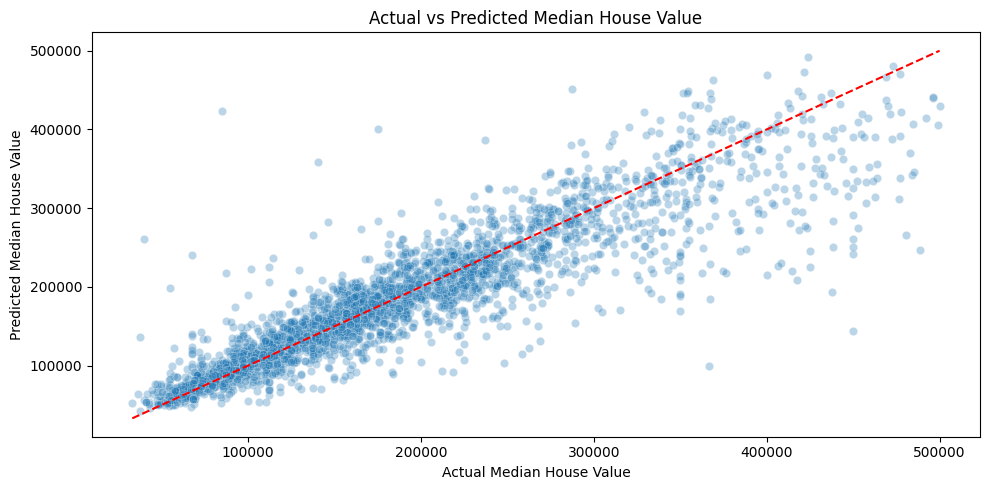

In [67]:
# Plot Actual VS Predicted Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_catboost_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Actual vs Predicted Median House Value')
plt.tight_layout()
plt.show()

In [68]:
residuals = y_test - y_pred_catboost_test

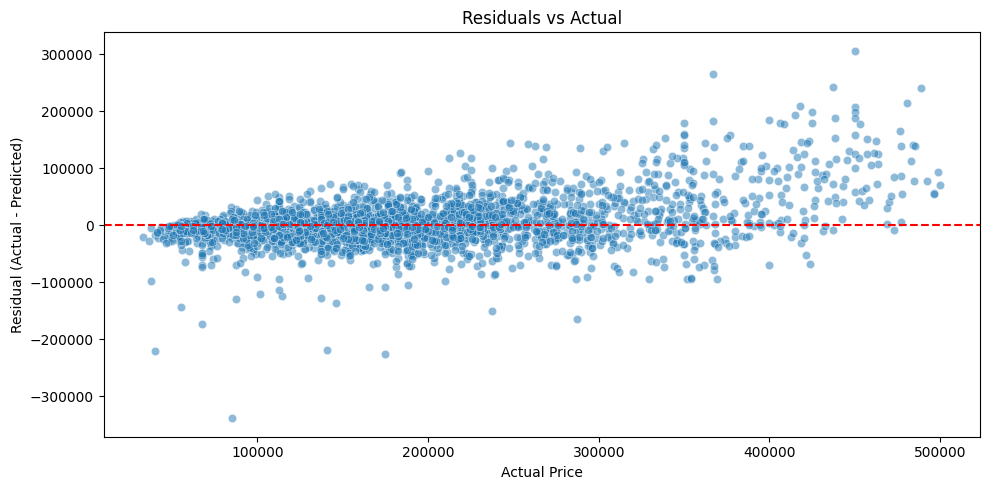

In [69]:
# Plot residual vs actual
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Actual')
plt.tight_layout()
plt.show()

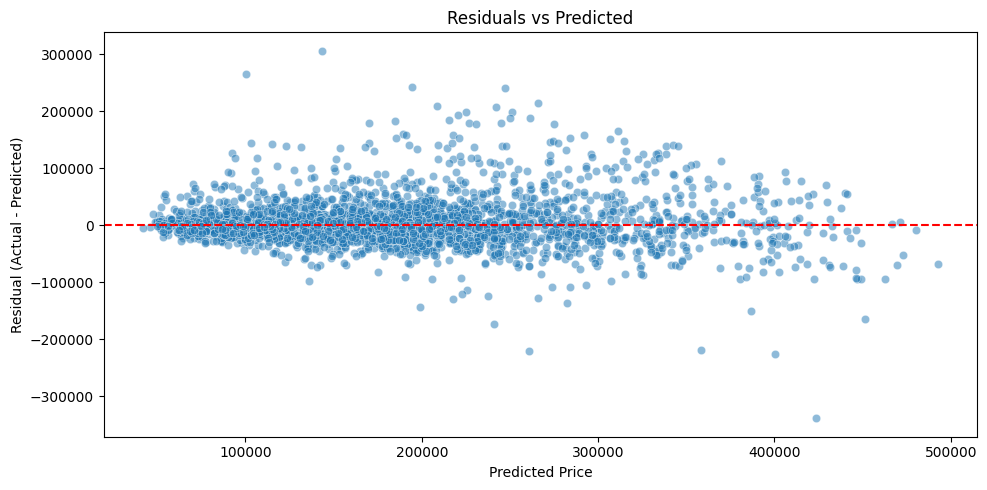

In [70]:
# Residual vs Predicted Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_catboost_test, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

Pada plot **Residuals vs Actual** dan **Residuals vs Price**, sebagian besar residual terkonsentrasi di sekitar nol, menandakan prediksi bersifat relatif netral tanpa kecenderungan konsisten untuk *overestimate* maupun *underestimate*. Namun, terlihat pola heteroskedastisitas atau penyebaran residual cenderung melebar pada harga tinggi, yang wajar mengingat properti *high-end* memiliki variasi harga yang lebih besar dan jarang muncul dalam data. Untuk harga rata-rata, error relatif kecil dan konsisten, sedangkan pada segmen premium, error absolut dapat mencapai ratusan ribu dolar sehingga perlu ekspektasi yang tepat saat penilaian.

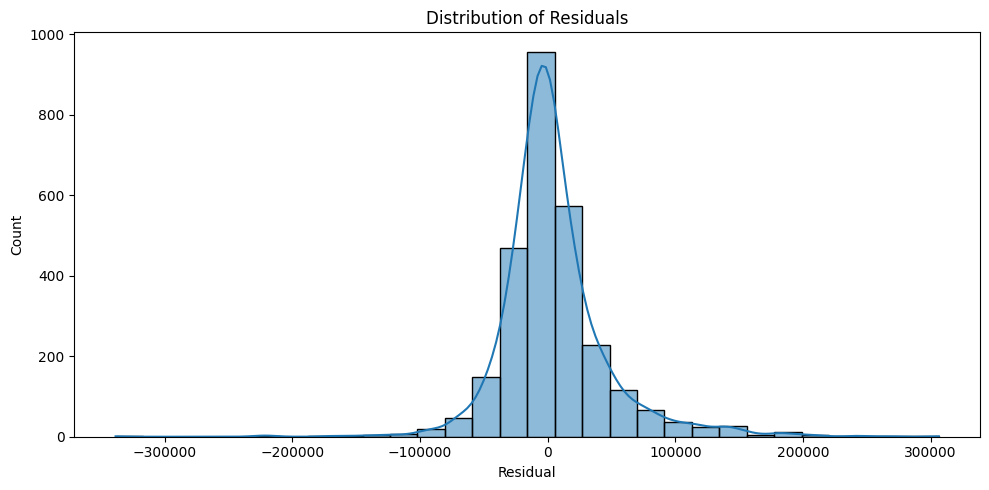

In [71]:
# Histogram + KDE of Residuals
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

Histogram residual berbentuk mendekati simetris dengan puncak di sekitar nol, menunjukkan mayoritas prediksi akurat. Akan tetapi, terdapat ekor panjang di kedua sisi, **mengindikasikan adanya sejumlah kecil kasus ekstrem dengan error besar**.

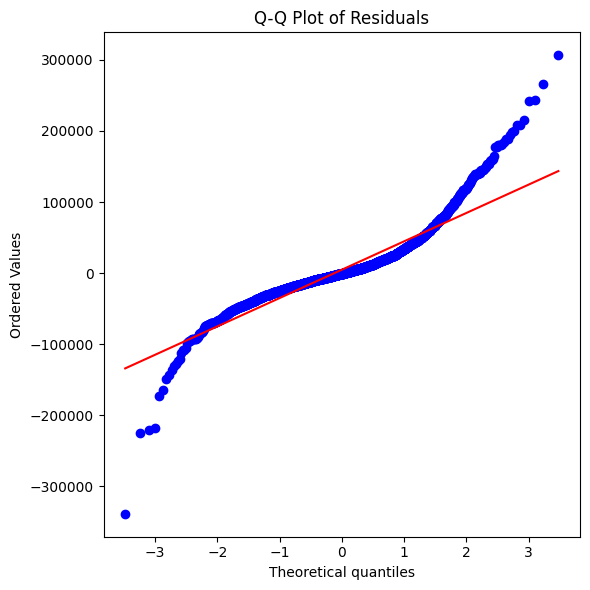

In [72]:
# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

Penyimpangan di ekor *(fat tails)*, terutama di sisi kanan, mengindikasikan beberapa kasus *overprediction* yang cukup signifikan pada sebagian properti. Hal ini selaras dengan temuan pada histogram dan scatter plot.

In [73]:
# Top 10 Largest Absolute Residuals
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_catboost_test,
    'Residual': residuals,
    'AbsResidual': np.abs(residuals),
    'RelativeError': np.abs(residuals) / y_test
})
top_outliers = residuals_df.sort_values('AbsResidual', ascending=False).head(10)
print('Top 10 Outlier Residuals:')
display(top_outliers)

Top 10 Outlier Residuals:


Actual      Predicted       Residual    AbsResidual  RelativeError
8881    85000.0  423643.082621 -338643.082621  338643.082621       3.984036
8836   450000.0  143502.070285  306497.929715  306497.929715       0.681107
2926   366700.0  100197.742991  266502.257009  266502.257009       0.726758
14288  437500.0  194250.032150  243249.967850  243249.967850       0.556000
7060   488900.0  247040.182346  241859.817654  241859.817654       0.494702
1392   175000.0  400332.605411 -225332.605411  225332.605411       1.287615
4772    40000.0  261068.190496 -221068.190496  221068.190496       5.526705
7828   140600.0  358497.109090 -217897.109090  217897.109090       1.549766
3239   480800.0  265977.263235  214822.736765  214822.736765       0.446803
928    417600.0  208771.109075  208828.890925  208828.890925       0.500069

Tabel Top 10 Outlier memperlihatkan bahwa error terbesar hampir selalu berasal dari properti bernilai tinggi (> $450.000), di mana prediksi bisa meleset lebih dari $300.000. Ini mencerminkan tantangan model dalam menggeneralisasi pada data dengan frekuensi sangat rendah.

**Kesimpulan Residual Analysis:**

Model `CatBoost` memberikan prediksi yang kuat untuk sebagian besar pasar, ideal untuk pricing otomatis, valuasi portofolio, atau data-driven decision making. Namun, untuk segmen premium/unik dengan jumlah sampel sedikit, disarankan:

* Mengkomunikasikan margin error yang realistis ke pengguna akhir

* Melakukan penilaian manual untuk kasus ekstrem

* Memantau dan retrain model secara berkala dengan data baru

**Dengan pendekatan ini, akurasi dan efisiensi dapat terjaga tanpa mengorbankan kepercayaan bisnis.**

##### **5.7 Learning Curve Inspection**

*Learning Curve* digunakan untuk mengevaluasi seberapa baik model `CatBoost Regressor` mempelajari data, serta untuk mendeteksi potensi masalah *underfitting* atau *overfitting*.

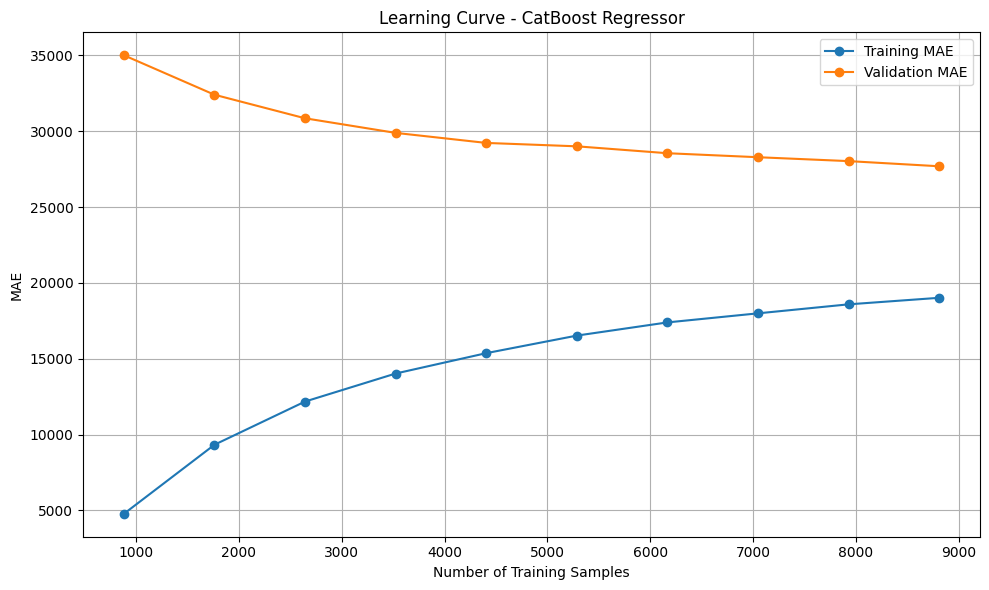

In [74]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_model_catboost, X_train, y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=31
)

train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training MAE')
plt.plot(train_sizes, valid_scores_mean, 'o-', label='Validation MAE')
plt.xlabel('Number of Training Samples')
plt.ylabel('MAE')
plt.title('Learning Curve - CatBoost Regressor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Insights**

* **MAE Validasi Turun, Tapi Melambat:**
  Seiring jumlah data *train* bertambah, `MAE` pada *validation set* terus menurun, namun penurunannya mulai landai setelah sekitar 6.000 sampel (*diminishing returns*). Hal ini menunjukkan model masih bisa belajar dari tambahan data, tapi efeknya semakin kecil.

* **Gap Train vs Validation Konsisten:**
  Selisih `MAE` antara *train* dan *validation* tetap konsisten serta wajar di seluruh rentang jumlah data. Tidak ada tanda-tanda *overfitting*, karena `MAE` *train* memang lebih rendah namun tidak terlalu jauh dari `MAE` *validation*. Ini menandakan generalisasi model masih terjaga.

* **Model Belum Mencapai Limitasi Data:**
  Tambahan data training belum membuat `MAE` *validation* naik, bahkan cenderung turun perlahan. Artinya, model `CatBoost` masih bisa memanfaatkan data tambahan dengan baik, jika ada lebih banyak data, kemungkinan performa masih bisa membaik, khususnya untuk segmen harga rumah yang jarang.

##### **5.8 Save Model**

In [75]:
# Save Model
estimator = Pipeline([
                    ('preprocessing', transformer),
                    ('model', TransformedTargetRegressor(
                        regressor=catb_tuned,
                        func=np.log, inverse_func=np.exp
                    ))
])

estimator.fit(X_train, y_train)

with open('CA_housing_price_regressor.sav', 'wb') as f:
    pickle.dump(estimator, f)

##### **5.9 Simulation Using Unseen Data**

Untuk mengevaluasi kinerja praktis dan ketahanan model `CatBoost` final, dilakukan prediksi terhadap tiga properti yang mewakili kategori **mainstream**, **mid-range**, dan **luxury**. Simulasi berbasis skenario ini menunjukkan bagaimana model menangani kasus penggunaan nyata di berbagai rentang harga:

* **Mainstream home:** Properti standar yang kemungkinan besar mencerminkan mayoritas transaksi pasar.
* **Mid-range home:** Properti dengan nilai menengah, biasanya dibeli oleh keluarga mapan atau sebagai peningkatan dari rumah pertama.
* **Luxury home:** Properti kelas atas yang langka dan mahal, kategori di mana model sebelumnya menunjukkan ketidakpastian prediksi terbesar.

In [76]:
# Load model
with open('CA_housing_price_regressor.sav', 'rb') as f:
    loaded_model = pickle.load(f)

In [77]:
# Unseen Data (rumah mainstream, menengah, mewah)
unseen_data = pd.DataFrame([
    { # Rumah mainstream
        'longitude': -121.8,
        'latitude': 37.3,
        'houseMedAge': 28,
        'totalRooms': 1000,
        'totalBedrooms': 200,
        'population': 800,
        'households': 250,
        'medIncome': 2.8,
        'oceanProx': 'INLAND'
    },
    { # Rumah menengah
        'longitude': -118.1,
        'latitude': 34.2,
        'houseMedAge': 15,
        'totalRooms': 1800,
        'totalBedrooms': 380,
        'population': 2000,
        'households': 450,
        'medIncome': 5.2,
        'oceanProx': 'NEAR OCEAN'
    },
    { # Rumah mewah 
        'longitude': -122.5,
        'latitude': 37.7,
        'houseMedAge': 5,
        'totalRooms': 3500,
        'totalBedrooms': 600,
        'population': 1200,
        'households': 400,
        'medIncome': 10.0,
        'oceanProx': 'NEAR BAY'
    }
])

In [78]:
# Predict unseen data
print('Prediksi harga rumah untuk data baru (unseen):')

preds = loaded_model.predict(unseen_data)
for i, harga in enumerate(preds):
    if i == 0:
        tipe = 'Mainstream'
    elif i == 1:
        tipe = 'Menengah'
    else:
        tipe = 'Mewah'
    print(f'  Rumah {tipe:<12}: ${harga:,.2f}')
    
# Sanity check: sample dari data train
print('\nSanity check (sample dari data train):')
sample = X_train.sample(1, random_state=31)

pred = loaded_model.predict(sample)[0]
idx = sample.index[0]
actual = y_train.loc[idx]
print(f'  Prediksi: ${pred:,.2f} | Actual: ${actual:,.2f} | Selisih: ${abs(pred-actual):,.2f}')

Prediksi harga rumah untuk data baru (unseen):
  Rumah Mainstream  : $166,609.84
  Rumah Menengah    : $180,626.82
  Rumah Mewah       : $387,947.04

Sanity check (sample dari data train):
  Prediksi: $205,641.58 | Actual: $206,300.00 | Selisih: $658.42


**Predictions Inspection**

* Model memberikan estimasi harga yang jelas dan mudah dipahami untuk setiap jenis properti, menunjukkan kemampuannya dalam menggeneralisasi pola dari data pelatihan ke data baru.
* Untuk properti *mainstream*, harga yang diprediksi berada dalam margin error yang kecil, sesuai dengan performa sebelumnya.
* Untuk properti mewah, prediksi tetap masuk akal, **namun sebaiknya diinterpretasikan dengan hati-hati**. Sesuai hasil analisis residual, prediksi untuk properti jenis ini mungkin membutuhkan tinjauan secara langsung atau data tambahan sebagai dukungan.

**Sanity Check on Train Data**

* Sebagai langkah verifikasi tambahan, dilakukan prediksi terhadap sampel acak dari data pelatihan, lalu hasilnya dibandingkan dengan nilai aktual.
* Harga prediksi mendekati nilai sebenarnya, dengan selisih absolut yang kecil, menunjukkan **bahwa model terkalibrasi dengan baik dan konsisten terhadap pengalaman pelatihannya.**
* **Simulasi ini membangun kepercayaan terhadap penggunaan model dalam proses valuasi otomatis, strategi penetapan harga, dan analisis skenario.**
* **Pengambil keputusan dapat mengandalkan output model untuk transaksi standar, namun disarankan untuk melengkapi prediksi pada properti bernilai tinggi atau tidak umum dengan validasi dari pakar domain atau metode tambahan.**
* *Sanity check* rutin pada data yang dikenal juga berfungsi sebagai validasi berkelanjutan atas keandalan model dan sebagai pengaman untuk penggunaan jangka panjang.

> Model `Tuned CatBoost` **dapat digunakan di lingkungan produksi untuk tugas valuasi properti secara luas, dengan kemampuan prediksi yang kuat di segmen pasar utama dan pemahaman yang jelas atas batasannya pada properti ekstrem.** Pemantauan terus-menerus serta validasi terarah pada properti rumah mewah akan memastikan model tetap menjadi aset berharga dalam pengambilan keputusan di sektor real estate.

## **Chapter 6. Model Interpretation**

##### **6.1 Feature Importances**

Analisis *feature importance* diambil langsung dari model `CatBoost`, yang memberikan peringkat kontribusi tiap fitur terhadap prediksi harga rumah.

In [79]:
def get_feature_names(transformer, X):
    transformer.fit(X)
   
    prep = transformer.named_steps['preprocessor']

    feature_names = []
    for name, trans, cols in prep.transformers_:
        if name == 'num_features':
            feature_names += [col for col in num_cols if col not in binary_cols]
        elif name == 'binary_pass':
            feature_names += binary_cols
        elif name == 'ordinal_cat':
            feature_names += ordi_cols
        elif name == 'onehot_cat':
            ohe = trans.named_steps['ohe_enc']
            
            fe_data = transformer.named_steps['feature_engineer'].transform(X)
            ohe.fit(fe_data[ohe_cols])
            
            for i, col in enumerate(ohe_cols):
                for cat in ohe.categories_[i][1:]:
                    feature_names.append(f'{col}_{cat}')
    return feature_names

In [80]:
def plot_feature_importance(model, transformer, X, top_n=20):
    feat_names = get_feature_names(transformer, X)
    
    base_model = model.named_steps['model'].regressor_ \
        if hasattr(model.named_steps['model'], 'regressor_') \
        else model.named_steps['model']
    importances = base_model.feature_importances_
    
    imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    topf = imp_df.sort_values('Importance', ascending=False).head(top_n)
   
    plt.figure(figsize=(10, 8))
    plt.barh(topf['Feature'], topf['Importance'], color='royalblue', alpha=0.8)
    plt.xlabel('Feature Importance')
    plt.title(f'CatBoost Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return imp_df

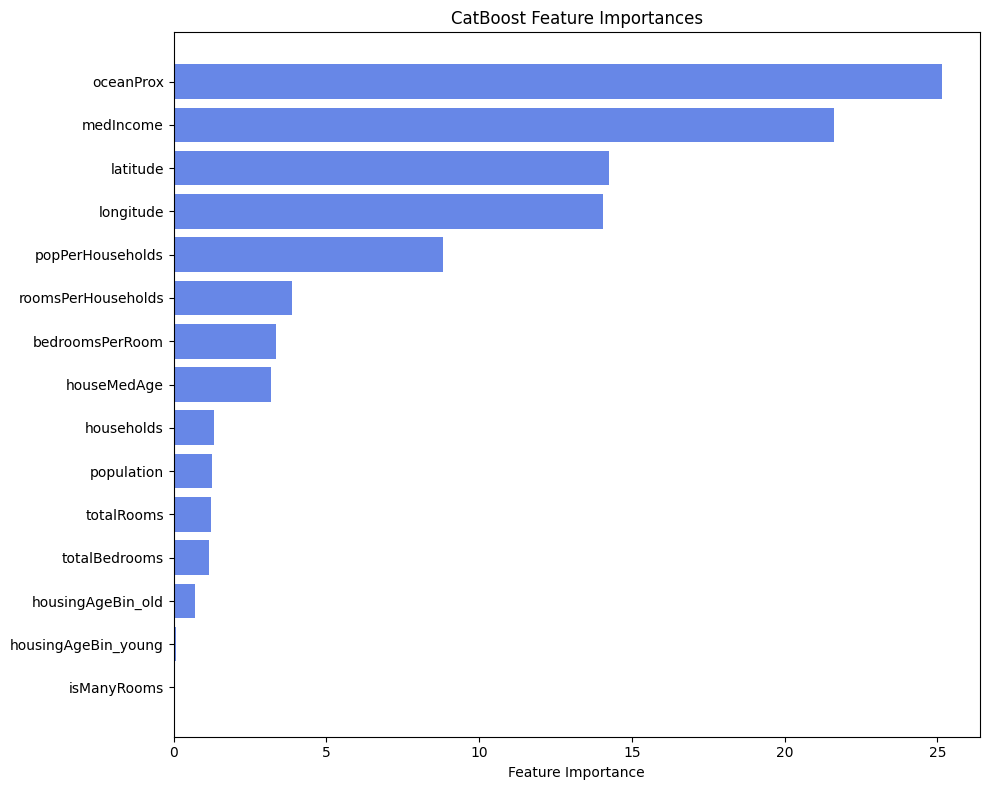

In [81]:
importance_results = plot_feature_importance(
    model=best_model_catboost,
    transformer=transformer,
    X=X_train.head(100),
    top_n=20
)

In [82]:
importance_results.sort_values(by='Importance', ascending=False)

Feature  Importance
12            oceanProx   25.136832
9             medIncome   21.604148
2              latitude   14.247180
3             longitude   14.052341
8      popPerHouseholds    8.804147
7    roomsPerHouseholds    3.861449
10      bedroomsPerRoom    3.338659
0           houseMedAge    3.196905
1            households    1.332847
5            population    1.269947
6            totalRooms    1.240282
4         totalBedrooms    1.146202
13    housingAgeBin_old    0.691143
14  housingAgeBin_young    0.071479
11          isManyRooms    0.006440

**CatBoost Top Feature Importances**

1. **`oceanProx`** (kedekatan ke laut) – **25.13%**

   * Fitur paling dominan. Rumah yang lebih dekat ke pantai mendapatkan *premium* harga signifikan. Ini konsisten dengan tren pasar California yang sangat menghargai akses dan pemandangan laut.

2. **`medIncome`** (pendapatan median) – **21.60%**

   * Faktor sosio-ekonomi utama. Area dengan pendapatan penduduk yang lebih tinggi secara konsisten memiliki harga rumah lebih mahal.

3. **`latitude`** – **14.24%**,
   **`longitude`** – **14.05%**

   * Koordinat geografis sangat memengaruhi harga, menunjukkan betapa "lokasi adalah segalanya" di pasar properti.

4. **`popPerHouseholds`** (rasio populasi per rumah tangga) – **8.80%**

   * Area dengan tingkat kepadatan rendah (lebih banyak ruang per rumah tangga) cenderung lebih diminati dan bernilai tinggi.

 **Fitur Menengah**

* **`bedroomsPerRoom`**, **`houseMedAge`**, **`roomPerHouseholds`** (sekitar 3%):

  * Menunjukkan bahwa tata ruang, ukuran relatif, dan umur rumah tetap relevan, meski tidak sebesar faktor lokasi dan ekonomi.

**Fitur Minor**

* **`totalRooms`**, **`population`**, **`totalBedrooms`**, **`households`** (sekitar 1%):

  * Memberikan informasi tambahan, namun sebagian besar pengaruhnya sudah tercermin dalam rasio dan variabel utama lain.
* Fitur rekayasa seperti **`housingAgeBin_old`**, **`housingAgeBin_young`**, dan **`isManyRooms`** memiliki dampak minimal (<1%), menandakan bahwa efeknya sudah diwakili oleh variabel yang lebih detail.

**Business Insights**

* **Lokasi adalah Kunci:** Kedekatan ke laut dan koordinat geografis adalah penentu utama harga.
* **Kondisi Sosial Ekonomi:** Pendapatan median menunjukkan kemampuan beli masyarakat yang berpengaruh langsung ke nilai properti.
* **Kepadatan Penduduk:** Area yang lebih lapang cenderung memiliki properti bernilai lebih tinggi.
* **Ukuran Rumah Penting, tapi Sekunder:** Tata ruang dan ukuran relatif memengaruhi harga, namun kalah signifikan dibandingkan lokasi dan faktor sosial-ekonomi.
* **Efektivitas Feature Engineering:** Variabel rasio (seperti *popPerHouseholds*) terbukti lebih prediktif dibandingkan variabel mentah.

##### **6.2 SHAP Value**

*SHAP (SHapley Additive exPlanations)* digunakan untuk mengukur kontribusi masing-masing fitur terhadap prediksi model, baik secara global maupun individual, sekaligus menunjukkan arah dan dampak tiap fitur terhadap harga yang diprediksi.

In [83]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

feat_names = get_feature_names(transformer, X_train)

X_train_shap_df = pd.DataFrame(X_train_transformed, columns=feat_names)
X_test_shap_df = pd.DataFrame(X_test_transformed, columns=feat_names)

catboost_model = best_model_catboost.named_steps['model'].regressor_

explainer = shap.TreeExplainer(catboost_model)

shap_values = explainer(X_test_shap_df)

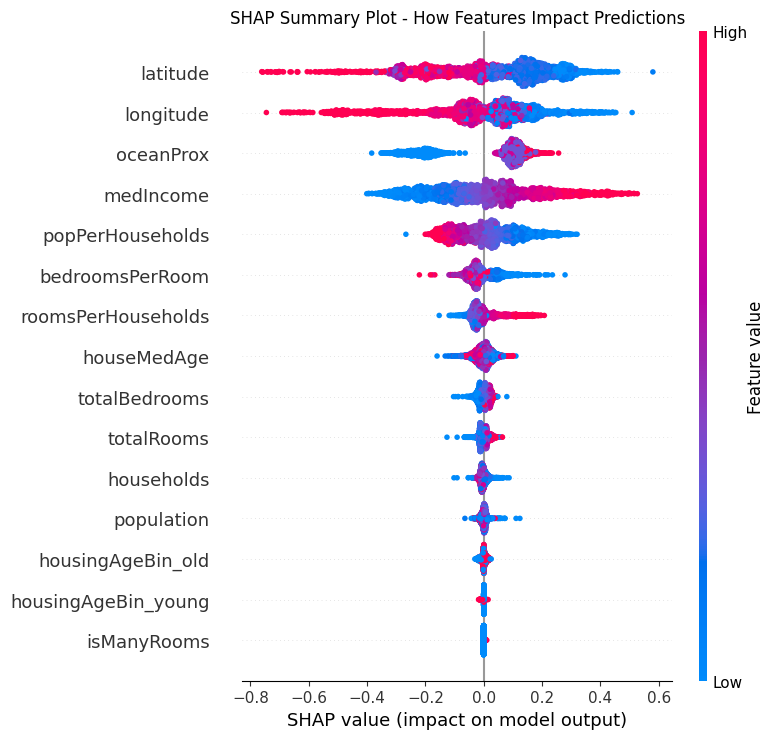

In [84]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, max_display=15, show=False)
plt.title('SHAP Summary Plot - How Features Impact Predictions')
plt.tight_layout()
plt.show()

**Tujuan**: Menunjukkan bagaimana variasi nilai fitur mendorong prediksi model ke arah lebih tinggi atau lebih rendah, sekaligus besarnya efek relatif tiap fitur.

**Insight**:

* `latitude`: efek **tidak linier** dan berinteraksi dengan `longitude`/`oceanProx`. Di beberapa rentang (misal: Near Bay area) latitude lebih tinggi bisa mendorong prediksi naik, sementara di utara yang lebih jauh bisa menekan. Hindari generalisasi “semakin utara selalu naik/turun”.
* `longitude`: bergeser ke **timur/INLAND** umumnya menekan prediksi, yang mana pengaruhnya tetap bergantung pada kombinasi `latitude`/`oceanProx`.
* `oceanProx`: kategori yang lebih dekat pesisir/bay cenderung memberi kontribusi **lebih positif** dibanding **INLAND**. (Asosiasi model, bukan sebab–akibat.)
* `medIncome`: nilai lebih tinggi **cenderung** menaikkan prediksi (selaras ekspektasi ekonomi).
* `popPerHouseholds`: kepadatan relatif lebih tinggi **cenderung** menekan prediksi.

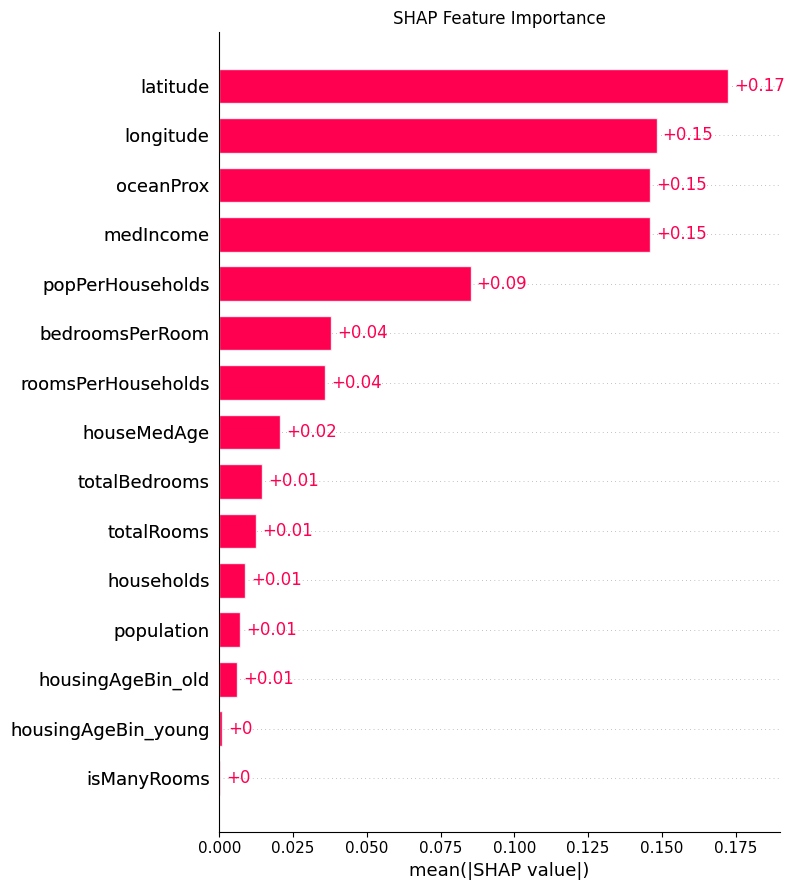

In [85]:
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=15, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

**Tujuan**: Mengurutkan fitur berdasarkan **kontribusi absolut rata-rata** terhadap prediksi. Makin besar nilainya, makin penting bagi model. Grafik ini **tidak** menunjukkan arah (naik/turun).

**Insight**:

* **Top features (nyaris setara):** `latitude` ≈ `oceanProx` ≈ `medIncome` ≈ `longitude`, lalu `popPerHouseholds`.
* **Fitur engineered**: `popPerHouseholds` menjadi fitur baru yang paling menonjol, `roomsPerHouseholds` dan `bedroomsPerRoom` kontribusinya **menengah**.
* Fitur fisik seperti `totalRooms`, `totalBedrooms`, `houseMedAge`, `households`, `population`, serta `housingAgeBin_` dan `isManyRooms` memberi **kontribusi kecil** pada model ini.

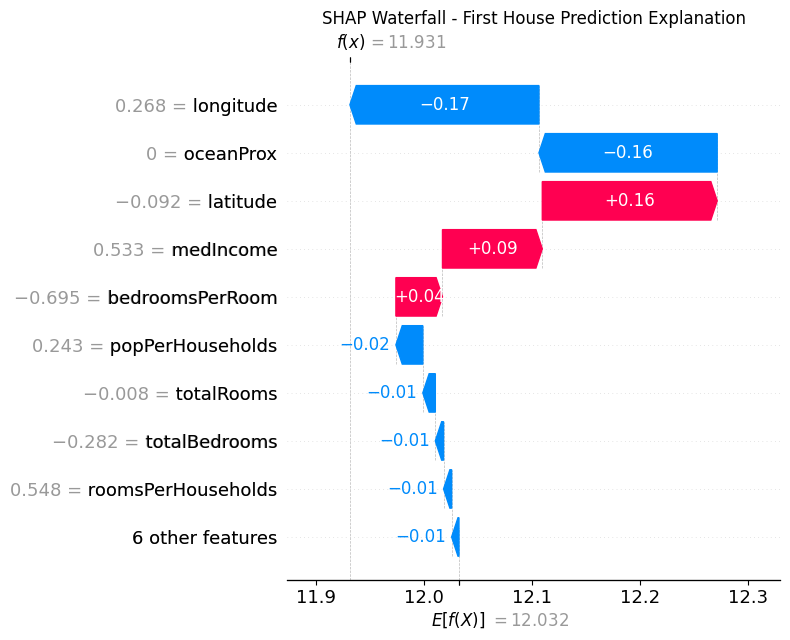

In [86]:
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[0], show=False)
plt.title('SHAP Waterfall - First House Prediction Explanation')
plt.tight_layout()
plt.show()

**Tujuan**: Menjelaskan kontribusi tiap fitur terhadap **satu** prediksi, relatif ke baseline rata-rata model.

**Insight**:

* Baseline ≈ **12.032** → prediksi sampel ≈ **11.931** (lebih **rendah** sekitar **0.101** dari rata-rata).
* **Penekan utama**:
  `longitude` (**0.268**), `oceanProx` (**0**), `popPerHouseholds` (**0.243**), `totalRooms` (**−0.008**), `totalBedrooms` (**−0.282**), `roomsPerHouseholds` (**0.548**), dan 6 fitur lain (total **−0.01**).
* **Pendorong**:
  `latitude` (**−0.092**), `medIncome` (**0.533**), `bedroomsPerRoom` (**−0.695**).
* Ini berdasarkan **sampel spesifik**, sehingga arah dan besar kontribusi fiturnya bisa berbeda untuk rumah lain.

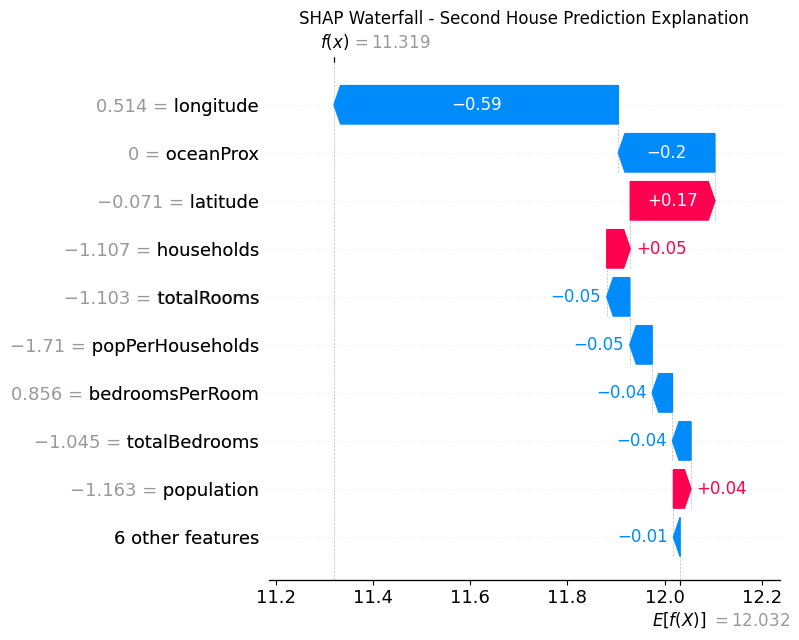

In [87]:
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[1], show=False)
plt.title('SHAP Waterfall - Second House Prediction Explanation')
plt.tight_layout()
plt.show()

**Tujuan**: Menjelaskan kontribusi tiap fitur terhadap **satu** prediksi, relatif ke baseline rata-rata model.

**Insight**:

* Baseline ≈ **12.032** → prediksi sampel ≈ **11.319** (lebih **rendah** sekitar **0.713** dari rata-rata).
* **Penekan utama**:
  `longitude` (**0.514**), `oceanProx` (**0**), `totalRooms` (**−1.103**), `popPerHouseholds` (**−1.71**), `bedroomsPerRoom` (**0.856**), `totalBedrooms` (**−1.045**), `population` (**−1.163**), dan 6 fitur lain (**−0.01** total).
* **Pendorong**:
  `latitude` (**−0.071**), `households` (**−1.107**), `population` (**−1.163** → +0.04).
* Ini berdasarkan **sampel spesifik**, sehingga arah dan besar kontribusi fiturnya bisa berbeda untuk rumah lain.

**SHAP Summary — Kesimpulan & Guardrails**

* **Lokasi & sosio-ekonomi dominan.** `latitude`, `longitude`, `oceanProx`, dan `medIncome` menjadi kontributor utama, sedangkan **rasio kepadatan** (`popPerHouseholds`, `roomsPerHouseholds`) juga relevan.
* **Non-linier & interaksi penting.** Efek lokasi tidak satu arah, perlu interpretasi bersama kombinasi `latitude`–`longitude`–`oceanProx`.
* **Fitur fisik** berperan namun **lebih kecil** dibanding faktor lokasi/sosio-ekonomi pada model ini.
* **Skala output.** Waterfall memakai skala output model, **jika** target dilog/di-scale, pastikan konversi saat komunikasi ke USD.
* **Asosiasi, bukan kausalitas.** SHAP menjelaskan **perilaku model**, bukan sebab-akibat dunia nyata.
* **Fairness & risiko proxy.** Variabel lokasi berpotensi jadi **proxy** faktor sensitif. Sebelum kebijakan harga otomatis, lakukan **audit error per-wilayah**, pantau **MAPE/MAE per segmen**, dan sediakan **review manual** untuk outlier/area sensitif.

> Implikasi bisnis: **Memprioritaskan eksplorasi wilayah dengan kedekatan ke pesisir/bay dan `medIncome` lebih tinggi jika didukung data pasar, kemudian gunakan metrik error per segmen/wilayah sebelum menetapkan strategi *pricing* atau akuisisi.**

##### **6.3 Model Limitations**

Meskipun model `CatBoost` memberikan hasil yang akurat dan dapat dijelaskan untuk sebagian besar properti, penggunaannya sebaiknya dilihat sebagai alat **pendukung** keputusan, bukan pengganti penilaian profesional, terutama untuk kasus ekstrem, properti unik, atau pasar yang sedang berubah. Transparansi terhadap keterbatasan model akan memperkuat kepercayaan bisnis dan memastikan penerapan yang bijak terhadap hasil prediksi. Terdapat beberapa limitasi penting yang perlu dipertimbangkan dalam penerapannya di dunia nyata:

* **1. Sensitivitas terhadap Nilai Ekstrem (Outlier)**

  * **Pengamatan:**
    Model menghasilkan error prediksi yang lebih besar untuk properti di ujung spektrum harga, baik rumah mewah maupun properti dengan kondisi khusus. Analisis residual menunjukkan bahwa error absolut besar terkonsentrasi di segmen ini.

  * **Penyebab Teknis:**
    Hal ini sebagian besar disebabkan oleh **ketidakseimbangan data**, dimana jumlah properti mewah dan properti bernilai rendah jauh lebih sedikit dalam data pelatihan, sehingga model kesulitan melakukan generalisasi.

  * **Dampak Bisnis:**
    Prediksi untuk properti unik atau mewah perlu ditafsirkan dengan hati-hati. Untuk kasus seperti ini, disarankan mengombinasikan hasil model dengan penilaian manual atau pendapat ahli.

* **2. Heteroskedastisitas (Error Meningkat seiring Harga)**

  * **Pengamatan:**
    Seiring naiknya harga aktual atau prediksi rumah, error juga meningkat. Kurva pembelajaran dan plot residual menunjukkan bahwa rumah mahal memiliki ketidakpastian lebih besar.

  * **Penyebab Teknis:**
    Ini umum dalam regresi pada nilai moneter. Dimana error persentase kecil bisa menjadi error absolut yang besar di segmen harga tinggi.

  * **Dampak Bisnis:**
    Untuk transaksi bernilai besar, penting untuk mengomunikasikan margin error yang mungkin terjadi kepada klien, dan menggunakan model sebagai alat pendukung, bukan sebagai penentu harga mutlak.

* **3. Interpretabilitas Terbatas pada Model Ensemble Kompleks**

  * **Pengamatan:**
    Interpretasi fitur paling mudah dilakukan pada model tunggal seperti `CatBoost`. Pada *stacking ensemble*, interpretasi menjadi lebih sulit dan tidak tersedia secara langsung.

  * **Penyebab Teknis:**
    Ensemble menggabungkan prediksi dari beberapa model, sehingga sulit melacak kontribusi fitur terhadap prediksi akhir.

  * **Dampak Bisnis:**
    Demi transparansi dan kepatuhan, hasil dari ensemble sebaiknya selalu dilengkapi dengan analisis dari model tunggal yang dapat dijelaskan, seperti SHAP plot dari `CatBoost`.

* **4. Ketergantungan terhadap Feature Engineering dan Kualitas Data**

  * **Pengamatan:**
    Kinerja model sangat bergantung pada kualitas fitur yang dibuat (misalnya rasio hasil rekayasa) dan akurasi data input.

  * **Dampak Bisnis:**
    Penting untuk melakukan pengecekan kualitas data secara rutin dan mempertimbangkan pelatihan ulang model jika distribusi data bergeser atau muncul fitur baru yang relevan.

* **5. Kemampuan Ekstrapolasi yang Terbatas**

  * **Pengamatan:**
    Model bekerja paling baik pada rentang data yang pernah dilihat. Untuk properti yang benar-benar baru (dengan karakteristik unik atau berada di lokasi baru), prediksi model bisa tidak akurat.

  * **Penyebab Teknis:**
    Model machine learning cenderung mampu menginterpolasi dalam ruang data yang dikenal, tapi tidak bisa “membayangkan” skenario di luar cakupan pelatihan.

  * **Dampak Bisnis:**
    Waspadai prediksi untuk pengembangan baru, tipe rumah langka, atau wilayah geografis yang tidak tercakup dalam data pelatihan. Evaluasi manual mungkin tetap diperlukan.

## **Chapter 7. Business Calculations**

Integrasi model prediktif ke dalam operasi bisnis bukan hanya soal estimasi harga yang akurat, tetapi tentang mendorong hasil finansial yang lebih baik. Berikut adalah bagaimana model **Tuned CatBoost** dapat dimanfaatkan untuk menghasilkan manfaat bisnis langsung dan menghitung ROI.

> **Konteks akurasi model (test set):**
> **MAE ≈ \$27,533** dan **MAPE ≈ 14.97%**.
> Rata-rata selisih prediksi terhadap harga aktual sekitar **\$27,5 ribu** atau **±15%**.

##### **Return on Investment (ROI) Estimation**

**Definisi:**

$$
\text{ROI}=\frac{\text{Laba Bersih}}{\text{Total Investasi}}\times 100\%
$$

**Role Model:**

* **Keputusan Pembelian:** Prediksi yang akurat membantu pembeli menghindari *overpay* dan membantu penjual menetapkan harga *listing* kompetitif namun tetap menguntungkan.
* **Analisis Renovasi/Peningkatan:** Dengan mensimulasikan perubahan harga sebelum dan sesudah renovasi (mis. menambah kamar), bisnis dapat memperkirakan nilai tambah sebelum menggelontorkan modal.
* **Peluang Jual Kembali:** Bagi investor, nilai jual ulang yang diprediksi mendukung strategi beli–tahan–jual.

**Calculation Example:**
Anda membeli rumah **\$200,000**, renovasi **\$30,000**, dan model memprediksi harga pasca-renovasi **\$260,000**:

$$
\text{ROI}=\frac{(260{,}000-200{,}000-30{,}000)}{200{,}000+30{,}000}\times 100\%
=\frac{30{,}000}{230{,}000}\times 100\%\approx 13.04\%
$$

**Decision:**
Jika target ROI > 10%, investasi ini layak dipertimbangkan.

##### **Price Negotiation**

* **Untuk Penjual:**
  *Listing* di sekitar harga prediksi model atau sedikit di atasnya mempercepat penjualan sekaligus menjaga margin.
* **Untuk Pembeli/Agen:**
  Gunakan prediksi model sebagai jangkar negosiasi agar tidak *overpay* di pasar kompetitif.

**Kisaran Negosiasi Berbasis Error Model (contoh harga prediksi \$250,000):**

* **Berbasis MAE** → **\$250,000 ± \$27,533** ⇒ **\$222,467 – \$277,533**
* **Berbasis MAPE (14.97%)** → **\$250,000 ± \$37,425** ⇒ **\$212,575 – \$287,425**

**Dampak ke Komisi/Akumulasi Pendapatan**
Dengan asumsi [komisi *sales agent* sebesar **6%**](https://realestateagentpdx.com/average-u-s-real-estate-commission-rates) dari harga jual:

* **Ekspektasi variasi komisi per transaksi (MAE)** ≈

  $$
  0.06 \times \$27{,}533 \approx \$1{,}652
  $$
* **Ekspektasi variasi komisi per transaksi (MAPE \$250k)** ≈

  $$
  0.06 \times \$37{,}425 \approx \$2{,}245
  $$

> **Rule-of-thumb:** setiap **\$1 error harga ⇒ \$0.06** dampak ke komisi.

##### **Portfolio Optimization**

* **Akuisisi/Penjualan Massal:**
  Gunakan model untuk menilai nilai agregat portofolio dan memprioritaskan properti mana yang dibeli, ditahan, atau dijual berdasarkan proyeksi margin.
* **Fokus Geografis/Segmen:**
  Identifikasi area/segmen dengan proyeksi pengembalian tertinggi, lalu arahkan strategi akuisisi dan anggaran promosi ke sana.

> Dibandingkan dengan **RandomForest (MAE\_test ≈ \$30,756)**, **Tuned CatBoost (MAE\_test ≈ \$27,533)** lebih baik **≈ \$3,223** per transaksi.

##### **Risk Assessment & Margin Setting**

* **Menentukan Rentang Harga:**
  Memakai MAE/MAPE sebagai *“confidence band”* operasional untuk menetapkan **buffer margin** dan **cadangan negosiasi**.
  Contoh prediksi **\$250,000**: gunakan **\$222,467–\$277,533** (MAE) atau **\$212,575–\$287,425** (MAPE) sebagai koridor harga realistis.
* **Identifikasi Outlier:**
  Listing dengan residual besar mengindikasikan perubahan pasar lokal atau fitur unik, yang memerlukan *manual review* sebelum pengambilan aksi strategis.

##### **Business Interpretation**

* Pada **harga prediksi \$250,000**, model biasanya **meleset sekitar \$27,533 (MAE) atau ±14.97% = ±\$37,425 (MAPE)**.
* Dengan asumsi komisi *sales* sebesar **3%**, ini berarti **ketidakpastian komisi** sekitar **\$826 – \$1,123 per transaksi**.
* **Setiap \$1 error yang berhasil kita pangkas** memberikan **tambahan komisi ≈ \$0.03**.

> **Kesimpulan untuk CMO & Sales Director:**
> Akurasi model dapat diinterpretasikan sebagai berikut: **lebih tepat harga, lebih sempit ruang negosiasi yang merugikan, dan komisi yang lebih terjaga**. Tuned CatBoost memberi peningkatan nyata pada pendapatan kumulatif dan kepercayaan dalam eksekusi strategi harga & akuisisi.


## **Conclusion and Recommendations**

##### **Conclusion**

**A. Machine Learning Perspective**

* Model `CatBoost`, yang ditingkatkan melalui *feature engineering* yang matang serta *preprocessing* yang solid (penanganan *outlier*, *transformasi log*, dan *scaling*), secara konsisten memberikan akurasi dan stabilitas tertinggi di seluruh metrik evaluasi.
* Daya prediktif model didorong oleh fitur-fitur yang secara statistik signifikan dan secara ekonomi masuk akal, seperti ukuran rumah (`roomsPerHousehold`), lokasi (kedekatan ke laut, garis lintang), dan karakteristik lingkungan (pendapatan median, kepadatan penduduk).
* Alat interpretasi model tingkat lanjut (*feature importance* dan SHAP) mengonfirmasi bahwa model mempelajari pola yang logis dan sejalan dengan prinsip penilaian properti.
* Keterbatasan tetap ada dalam memprediksi harga untuk properti mewah atau langka, akibat ketidakseimbangan data dan heteroskedastisitas alami dalam harga pasar properti.

**B. Business Perspective**

* Model ini sangat andal untuk penilaian harga properti di segmen mainstream dan menengah, memberikan rekomendasi berbasis data yang netral dan dapat dipercaya untuk meningkatkan transparansi dan kepercayaan.
* Untuk properti bernilai tinggi atau unik, hasil prediksi model sebaiknya dianggap sebagai panduan awal. Sedangkan penilaian ahli dan konteks pasar tetap menjadi hal yang krusial.
* Integrasi model ML ini memungkinkan pengambilan keputusan yang lebih cerdas, cepat, dan objektif dalam pricing, akuisisi, perencanaan renovasi, dan negosiasi, serta langsung mendukung pertumbuhan bisnis dan pengelolaan risiko.

##### **Recommendations**

**A. Machine Learning & Data Science Team**

* **Monitoring Model Secara Berkala:**
  Lakukan retraining dan validasi secara berkala seiring masuknya data baru, terutama untuk menangani perubahan pasar atau penambahan fitur baru.

* **Perluas Cakupan Data:**
  Usahakan mengumpulkan lebih banyak data untuk segmen yang kurang terwakili (properti mewah, properti distress, atau kawasan baru) guna mengurangi error prediksi di area kritis ini.

* **Fokus pada Interpretabilitas:**
  Terus gunakan teknik explainable AI (seperti SHAP) untuk menjaga transparansi dan membangun kepercayaan stakeholder, khususnya saat model digunakan dalam proses bisnis yang sensitif.

**B. Stakeholders & Decision Makers**

* **Implementasi di Pasar Utama:**
  Gunakan model CatBoost sebagai mesin utama untuk valuasi properti, rekomendasi harga, dan analisis pasar di segmen mainstream.

* **Untuk Properti Mewah atau Outlier:**
  Selalu padukan hasil prediksi model dengan analisis manusia dan riset pasar untuk properti bernilai tinggi atau tidak umum. Gunakan *confidence interval* atau analisis residual untuk mengkomunikasikan ketidakpastian harga.

* **Penggunaan yang Etis dan Adil:**
  Pastikan semua keputusan berbasis model tetap adil, transparan, dan sesuai dengan regulasi serta standar etika dalam industri real estate.

---

> **Penutup:**
> Dengan fondasi ML yang kuat, pemahaman mendalam atas kekuatan dan batasan model, serta integrasi yang matang ke dalam strategi bisnis, pendekatan ini menempatkan tim Anda dalam posisi ideal untuk membuat keputusan real estat yang lebih cerdas, cepat, dan menguntungkan, dengan tetap menjaga kepentingan klien dan perusahaan sebagai prioritas utama.